In [1]:
from datasets import load_dataset

ds = load_dataset("artem9k/ai-text-detection-pile")
ds

/home/ml/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['source', 'id', 'text'],
        num_rows: 1392522
    })
})

In [2]:
import torch
torch.cuda.is_available()

True

Convert huggingface format to Pandas format

In [3]:
df = ds['train'].to_pandas()

In [4]:
df.shape

(1392522, 3)

In [5]:
df

,source,id,text
0,human,0,12 Years a Slave: An Analysis of the Film Essa...
1,human,1,20+ Social Media Post Ideas to Radically Simpl...
2,human,2,2022 Russian Invasion of Ukraine in Global Med...
3,human,3,533 U.S. 27 (2001) Kyllo v. United States: The...
4,human,4,A Charles Schwab Corporation Case Essay\n\nCha...
...,...,...,...
1392517,ai,1418649,"Today, I accomplished a major feat. I stepped ..."
1392518,ai,1418650,As rockets rain down from the sky\nEurope trem...
1392519,ai,1418651,"On January 6th, 2023, the world lost a true pi..."
1392520,ai,1418652,A gene bank is a repository of genetic materia...


In [6]:
# replace 'human' with 0, 'ai' with 1
df['source'] = df['source'].replace({'human': 0, 'ai': 1})
df

/tmp/ipykernel_3084521/3923059119.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['source'] = df['source'].replace({'human': 0, 'ai': 1})


,source,id,text
0,0,0,12 Years a Slave: An Analysis of the Film Essa...
1,0,1,20+ Social Media Post Ideas to Radically Simpl...
2,0,2,2022 Russian Invasion of Ukraine in Global Med...
3,0,3,533 U.S. 27 (2001) Kyllo v. United States: The...
4,0,4,A Charles Schwab Corporation Case Essay\n\nCha...
...,...,...,...
1392517,1,1418649,"Today, I accomplished a major feat. I stepped ..."
1392518,1,1418650,As rockets rain down from the sky\nEurope trem...
1392519,1,1418651,"On January 6th, 2023, the world lost a true pi..."
1392520,1,1418652,A gene bank is a repository of genetic materia...


## Prepocessing

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42
)

In [9]:
[len(train_df), len(test_df)]

[1114017, 278505]

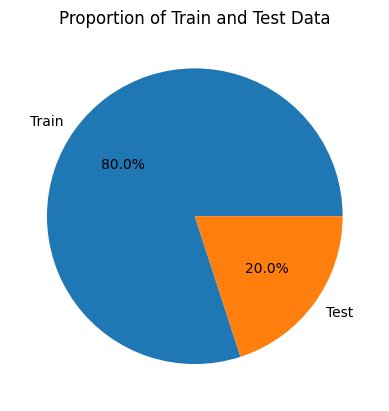

In [10]:
import matplotlib.pyplot as plt
plt.pie([len(train_df), len(test_df)], autopct='%1.1f%%', labels=['Train', 'Test'])
plt.title('Proportion of Train and Test Data')
plt.show()

### Set dataset format to tensors

In [ ]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset

model_id = 'roberta-base'
tokenizer = RobertaTokenizerFast.from_pretrained(model_id)

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=512)

train_encodings = train_df.map(tokenize, batched=True)
test_encodings = test_df.map(tokenize, batched=True)

In [ ]:
train_encodings = train_encodings.rename_column("source", "labels")
test_encodings = test_encodings.rename_column("source", "labels")

train_encodings = train_encodings.remove_columns([col for col in train_encodings.column_names if col not in ['input_ids', 'attention_mask', 'labels']])
test_encodings = test_encodings.remove_columns([col for col in test_encodings.column_names if col not in ['input_ids', 'attention_mask', 'labels']])

print(train_encodings.column_names)
print(test_encodings.column_names)

## Fine-tuning RoBERTa for text classification

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(model_id, num_labels=2)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    warmup_steps=1000,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    seed=42,
    fp16=True,
    gradient_accumulation_steps=1
)

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='binary')
    acc = accuracy_score(p.label_ids, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_encodings,
    eval_dataset=test_encodings,
    compute_metrics=compute_metrics
)

trainer.train()


Map: 100%|██████████| 278505/278505 [01:14<00:00, 3733.05 examples/s]


['labels', 'input_ids', 'attention_mask']
['labels', 'input_ids', 'attention_mask']


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ml/.local/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 51/104442 [00:08<4:23:03,  6.61it/s]

{'loss': 0.6999, 'grad_norm': 3.05501389503479, 'learning_rate': 1.5e-06, 'epoch': 0.0}


  0%|          | 101/104442 [00:15<4:24:04,  6.59it/s]

{'loss': 0.6078, 'grad_norm': 2.618144989013672, 'learning_rate': 2.9700000000000004e-06, 'epoch': 0.0}


  0%|          | 151/104442 [00:23<4:21:11,  6.65it/s]

{'loss': 0.4066, 'grad_norm': 2.530583381652832, 'learning_rate': 4.44e-06, 'epoch': 0.0}


  0%|          | 201/104442 [00:30<4:21:47,  6.64it/s]

{'loss': 0.2875, 'grad_norm': 13.66308879852295, 'learning_rate': 5.940000000000001e-06, 'epoch': 0.01}


  0%|          | 251/104442 [00:38<4:22:38,  6.61it/s]

{'loss': 0.1982, 'grad_norm': 23.46217155456543, 'learning_rate': 7.41e-06, 'epoch': 0.01}


  0%|          | 301/104442 [00:45<4:22:07,  6.62it/s]

{'loss': 0.1577, 'grad_norm': 37.074275970458984, 'learning_rate': 8.91e-06, 'epoch': 0.01}


  0%|          | 351/104442 [00:53<4:24:34,  6.56it/s]

{'loss': 0.1792, 'grad_norm': 20.472614288330078, 'learning_rate': 1.041e-05, 'epoch': 0.01}


  0%|          | 401/104442 [01:00<4:27:49,  6.47it/s]

{'loss': 0.115, 'grad_norm': 67.7027359008789, 'learning_rate': 1.1910000000000001e-05, 'epoch': 0.01}


  0%|          | 451/104442 [01:08<4:22:43,  6.60it/s]

{'loss': 0.1143, 'grad_norm': 10.183998107910156, 'learning_rate': 1.341e-05, 'epoch': 0.01}


  0%|          | 501/104442 [01:15<4:23:04,  6.59it/s]

{'loss': 0.1144, 'grad_norm': 1.8163487911224365, 'learning_rate': 1.488e-05, 'epoch': 0.01}


  1%|          | 551/104442 [01:23<4:20:09,  6.66it/s]

{'loss': 0.1036, 'grad_norm': 29.552465438842773, 'learning_rate': 1.6380000000000002e-05, 'epoch': 0.02}


  1%|          | 601/104442 [01:31<4:22:39,  6.59it/s]

{'loss': 0.133, 'grad_norm': 3.3193466663360596, 'learning_rate': 1.7879999999999998e-05, 'epoch': 0.02}


  1%|          | 651/104442 [01:38<4:27:38,  6.46it/s]

{'loss': 0.1054, 'grad_norm': 53.678863525390625, 'learning_rate': 1.938e-05, 'epoch': 0.02}


  1%|          | 701/104442 [01:46<4:21:55,  6.60it/s]

{'loss': 0.0882, 'grad_norm': 6.849036693572998, 'learning_rate': 2.088e-05, 'epoch': 0.02}


  1%|          | 751/104442 [01:53<4:24:26,  6.54it/s]

{'loss': 0.1496, 'grad_norm': 23.463655471801758, 'learning_rate': 2.238e-05, 'epoch': 0.02}


  1%|          | 801/104442 [02:01<4:21:15,  6.61it/s]

{'loss': 0.1326, 'grad_norm': 11.625764846801758, 'learning_rate': 2.3880000000000002e-05, 'epoch': 0.02}


  1%|          | 851/104442 [02:08<4:22:47,  6.57it/s]

{'loss': 0.1261, 'grad_norm': 15.114452362060547, 'learning_rate': 2.538e-05, 'epoch': 0.02}


  1%|          | 901/104442 [02:16<4:21:34,  6.60it/s]

{'loss': 0.0994, 'grad_norm': 1.812873125076294, 'learning_rate': 2.688e-05, 'epoch': 0.03}


  1%|          | 951/104442 [02:23<4:23:39,  6.54it/s]

{'loss': 0.1115, 'grad_norm': 10.406113624572754, 'learning_rate': 2.838e-05, 'epoch': 0.03}


  1%|          | 1001/104442 [02:31<4:19:52,  6.63it/s]

{'loss': 0.1315, 'grad_norm': 4.603343486785889, 'learning_rate': 2.9880000000000002e-05, 'epoch': 0.03}


  1%|          | 1051/104442 [02:38<4:20:04,  6.63it/s]

{'loss': 0.0953, 'grad_norm': 36.75032043457031, 'learning_rate': 2.998665919065757e-05, 'epoch': 0.03}


  1%|          | 1101/104442 [02:46<4:22:01,  6.57it/s]

{'loss': 0.1175, 'grad_norm': 13.659788131713867, 'learning_rate': 2.997215831093753e-05, 'epoch': 0.03}


  1%|          | 1151/104442 [02:54<4:19:59,  6.62it/s]

{'loss': 0.1018, 'grad_norm': 20.455148696899414, 'learning_rate': 2.9957657431217496e-05, 'epoch': 0.03}


  1%|          | 1201/104442 [03:01<4:23:23,  6.53it/s]

{'loss': 0.0935, 'grad_norm': 9.725485801696777, 'learning_rate': 2.9943156551497458e-05, 'epoch': 0.03}


  1%|          | 1251/104442 [03:09<4:23:18,  6.53it/s]

{'loss': 0.0984, 'grad_norm': 9.697884559631348, 'learning_rate': 2.992865567177742e-05, 'epoch': 0.04}


  1%|          | 1301/104442 [03:16<4:20:04,  6.61it/s]

{'loss': 0.0863, 'grad_norm': 7.9364423751831055, 'learning_rate': 2.9914154792057385e-05, 'epoch': 0.04}


  1%|▏         | 1351/104442 [03:24<4:20:43,  6.59it/s]

{'loss': 0.1141, 'grad_norm': 7.148746013641357, 'learning_rate': 2.989965391233735e-05, 'epoch': 0.04}


  1%|▏         | 1401/104442 [03:31<4:21:26,  6.57it/s]

{'loss': 0.0738, 'grad_norm': 0.6204772591590881, 'learning_rate': 2.9885153032617312e-05, 'epoch': 0.04}


  1%|▏         | 1451/104442 [03:39<4:20:31,  6.59it/s]

{'loss': 0.0668, 'grad_norm': 0.01937432959675789, 'learning_rate': 2.9870652152897277e-05, 'epoch': 0.04}


  1%|▏         | 1501/104442 [03:46<4:19:02,  6.62it/s]

{'loss': 0.0831, 'grad_norm': 26.201969146728516, 'learning_rate': 2.9856151273177243e-05, 'epoch': 0.04}


  1%|▏         | 1551/104442 [03:54<4:18:06,  6.64it/s]

{'loss': 0.0901, 'grad_norm': 13.78343391418457, 'learning_rate': 2.98416503934572e-05, 'epoch': 0.04}


  2%|▏         | 1601/104442 [04:01<4:17:36,  6.65it/s]

{'loss': 0.0802, 'grad_norm': 12.766152381896973, 'learning_rate': 2.9827149513737167e-05, 'epoch': 0.05}


  2%|▏         | 1651/104442 [04:09<4:19:37,  6.60it/s]

{'loss': 0.0657, 'grad_norm': 0.8336073756217957, 'learning_rate': 2.9812648634017132e-05, 'epoch': 0.05}


  2%|▏         | 1701/104442 [04:17<4:17:36,  6.65it/s]

{'loss': 0.0745, 'grad_norm': 8.204505920410156, 'learning_rate': 2.9798147754297094e-05, 'epoch': 0.05}


  2%|▏         | 1751/104442 [04:24<4:20:15,  6.58it/s]

{'loss': 0.1135, 'grad_norm': 0.7923000454902649, 'learning_rate': 2.978364687457706e-05, 'epoch': 0.05}


  2%|▏         | 1801/104442 [04:32<4:18:45,  6.61it/s]

{'loss': 0.0984, 'grad_norm': 18.07855796813965, 'learning_rate': 2.9769145994857024e-05, 'epoch': 0.05}


  2%|▏         | 1851/104442 [04:39<4:23:25,  6.49it/s]

{'loss': 0.0688, 'grad_norm': 25.98986053466797, 'learning_rate': 2.9754645115136986e-05, 'epoch': 0.05}


  2%|▏         | 1901/104442 [04:47<4:19:02,  6.60it/s]

{'loss': 0.1115, 'grad_norm': 14.399372100830078, 'learning_rate': 2.9740144235416948e-05, 'epoch': 0.05}


  2%|▏         | 1951/104442 [04:54<4:17:25,  6.64it/s]

{'loss': 0.0629, 'grad_norm': 11.699966430664062, 'learning_rate': 2.9725643355696914e-05, 'epoch': 0.06}


  2%|▏         | 2001/104442 [05:02<4:17:13,  6.64it/s]

{'loss': 0.0674, 'grad_norm': 12.705678939819336, 'learning_rate': 2.9711142475976876e-05, 'epoch': 0.06}


  2%|▏         | 2051/104442 [05:09<4:16:37,  6.65it/s]

{'loss': 0.0593, 'grad_norm': 4.323940277099609, 'learning_rate': 2.969664159625684e-05, 'epoch': 0.06}


  2%|▏         | 2101/104442 [05:17<4:21:07,  6.53it/s]

{'loss': 0.066, 'grad_norm': 9.7647066116333, 'learning_rate': 2.9682140716536806e-05, 'epoch': 0.06}


  2%|▏         | 2151/104442 [05:24<4:17:55,  6.61it/s]

{'loss': 0.0561, 'grad_norm': 48.45588302612305, 'learning_rate': 2.9667639836816768e-05, 'epoch': 0.06}


  2%|▏         | 2201/104442 [05:32<4:16:56,  6.63it/s]

{'loss': 0.0519, 'grad_norm': 6.155477523803711, 'learning_rate': 2.965313895709673e-05, 'epoch': 0.06}


  2%|▏         | 2251/104442 [05:39<4:16:48,  6.63it/s]

{'loss': 0.0916, 'grad_norm': 0.06440288573503494, 'learning_rate': 2.9638638077376695e-05, 'epoch': 0.06}


  2%|▏         | 2301/104442 [05:47<4:21:38,  6.51it/s]

{'loss': 0.0607, 'grad_norm': 6.649245738983154, 'learning_rate': 2.9624137197656657e-05, 'epoch': 0.07}


  2%|▏         | 2351/104442 [05:54<4:16:13,  6.64it/s]

{'loss': 0.0495, 'grad_norm': 0.0463515967130661, 'learning_rate': 2.9609636317936623e-05, 'epoch': 0.07}


  2%|▏         | 2401/104442 [06:02<4:15:22,  6.66it/s]

{'loss': 0.069, 'grad_norm': 14.407121658325195, 'learning_rate': 2.9595135438216588e-05, 'epoch': 0.07}


  2%|▏         | 2451/104442 [06:10<4:16:38,  6.62it/s]

{'loss': 0.0629, 'grad_norm': 0.18255607783794403, 'learning_rate': 2.958063455849655e-05, 'epoch': 0.07}


  2%|▏         | 2501/104442 [06:17<4:17:04,  6.61it/s]

{'loss': 0.0757, 'grad_norm': 9.643241882324219, 'learning_rate': 2.9566133678776515e-05, 'epoch': 0.07}


  2%|▏         | 2551/104442 [06:25<4:16:37,  6.62it/s]

{'loss': 0.0822, 'grad_norm': 7.872389316558838, 'learning_rate': 2.9551632799056477e-05, 'epoch': 0.07}


  2%|▏         | 2601/104442 [06:32<4:20:01,  6.53it/s]

{'loss': 0.0495, 'grad_norm': 1.2951637506484985, 'learning_rate': 2.953713191933644e-05, 'epoch': 0.07}


  3%|▎         | 2651/104442 [06:40<4:18:46,  6.56it/s]

{'loss': 0.0657, 'grad_norm': 0.015613512136042118, 'learning_rate': 2.9522631039616404e-05, 'epoch': 0.08}


  3%|▎         | 2701/104442 [06:47<4:19:06,  6.54it/s]

{'loss': 0.0725, 'grad_norm': 9.344717025756836, 'learning_rate': 2.950813015989637e-05, 'epoch': 0.08}


  3%|▎         | 2751/104442 [06:55<4:14:50,  6.65it/s]

{'loss': 0.0818, 'grad_norm': 5.183781147003174, 'learning_rate': 2.949362928017633e-05, 'epoch': 0.08}


  3%|▎         | 2801/104442 [07:02<4:15:51,  6.62it/s]

{'loss': 0.0602, 'grad_norm': 0.3242831230163574, 'learning_rate': 2.9479128400456297e-05, 'epoch': 0.08}


  3%|▎         | 2851/104442 [07:10<4:16:01,  6.61it/s]

{'loss': 0.0561, 'grad_norm': 11.006096839904785, 'learning_rate': 2.946462752073626e-05, 'epoch': 0.08}


  3%|▎         | 2901/104442 [07:17<4:15:03,  6.64it/s]

{'loss': 0.0543, 'grad_norm': 0.04098697751760483, 'learning_rate': 2.945012664101622e-05, 'epoch': 0.08}


  3%|▎         | 2951/104442 [07:25<4:16:44,  6.59it/s]

{'loss': 0.0555, 'grad_norm': 26.76426887512207, 'learning_rate': 2.9435625761296186e-05, 'epoch': 0.08}


  3%|▎         | 3001/104442 [07:33<4:15:38,  6.61it/s]

{'loss': 0.06, 'grad_norm': 0.16598325967788696, 'learning_rate': 2.942112488157615e-05, 'epoch': 0.09}


  3%|▎         | 3051/104442 [07:40<4:14:31,  6.64it/s]

{'loss': 0.0794, 'grad_norm': 0.6270946860313416, 'learning_rate': 2.9406624001856113e-05, 'epoch': 0.09}


  3%|▎         | 3101/104442 [07:48<4:15:46,  6.60it/s]

{'loss': 0.0555, 'grad_norm': 6.428350448608398, 'learning_rate': 2.939212312213608e-05, 'epoch': 0.09}


  3%|▎         | 3151/104442 [07:55<4:15:32,  6.61it/s]

{'loss': 0.0684, 'grad_norm': 25.549711227416992, 'learning_rate': 2.937762224241604e-05, 'epoch': 0.09}


  3%|▎         | 3201/104442 [08:03<4:16:01,  6.59it/s]

{'loss': 0.0522, 'grad_norm': 1.2380043268203735, 'learning_rate': 2.9363121362696002e-05, 'epoch': 0.09}


  3%|▎         | 3251/104442 [08:10<4:14:14,  6.63it/s]

{'loss': 0.0711, 'grad_norm': 2.6681854724884033, 'learning_rate': 2.9348620482975968e-05, 'epoch': 0.09}


  3%|▎         | 3301/104442 [08:18<4:14:39,  6.62it/s]

{'loss': 0.0405, 'grad_norm': 0.011233760975301266, 'learning_rate': 2.933411960325593e-05, 'epoch': 0.09}


  3%|▎         | 3351/104442 [08:25<4:15:27,  6.60it/s]

{'loss': 0.0542, 'grad_norm': 7.191415786743164, 'learning_rate': 2.9319618723535895e-05, 'epoch': 0.1}


  3%|▎         | 3401/104442 [08:33<4:15:14,  6.60it/s]

{'loss': 0.0466, 'grad_norm': 0.14943744242191315, 'learning_rate': 2.930511784381586e-05, 'epoch': 0.1}


  3%|▎         | 3451/104442 [08:40<4:14:05,  6.62it/s]

{'loss': 0.0393, 'grad_norm': 12.443514823913574, 'learning_rate': 2.9290616964095822e-05, 'epoch': 0.1}


  3%|▎         | 3501/104442 [08:48<4:15:45,  6.58it/s]

{'loss': 0.0616, 'grad_norm': 2.435387372970581, 'learning_rate': 2.9276116084375787e-05, 'epoch': 0.1}


  3%|▎         | 3551/104442 [08:55<4:13:41,  6.63it/s]

{'loss': 0.0407, 'grad_norm': 0.5197139978408813, 'learning_rate': 2.926161520465575e-05, 'epoch': 0.1}


  3%|▎         | 3601/104442 [09:03<4:14:55,  6.59it/s]

{'loss': 0.062, 'grad_norm': 0.12822701036930084, 'learning_rate': 2.924711432493571e-05, 'epoch': 0.1}


  3%|▎         | 3651/104442 [09:11<4:15:58,  6.56it/s]

{'loss': 0.0467, 'grad_norm': 1.241512417793274, 'learning_rate': 2.9232613445215676e-05, 'epoch': 0.1}


  4%|▎         | 3701/104442 [09:18<4:15:07,  6.58it/s]

{'loss': 0.0523, 'grad_norm': 5.976281642913818, 'learning_rate': 2.9218112565495642e-05, 'epoch': 0.11}


  4%|▎         | 3751/104442 [09:26<4:16:05,  6.55it/s]

{'loss': 0.0513, 'grad_norm': 0.37577345967292786, 'learning_rate': 2.9203611685775604e-05, 'epoch': 0.11}


  4%|▎         | 3801/104442 [09:33<4:17:22,  6.52it/s]

{'loss': 0.0355, 'grad_norm': 0.25192683935165405, 'learning_rate': 2.918911080605557e-05, 'epoch': 0.11}


  4%|▎         | 3851/104442 [09:41<4:19:32,  6.46it/s]

{'loss': 0.044, 'grad_norm': 0.0653526559472084, 'learning_rate': 2.9174609926335534e-05, 'epoch': 0.11}


  4%|▎         | 3901/104442 [09:48<4:14:36,  6.58it/s]

{'loss': 0.0546, 'grad_norm': 6.244890213012695, 'learning_rate': 2.9160109046615493e-05, 'epoch': 0.11}


  4%|▍         | 3951/104442 [09:56<4:11:53,  6.65it/s]

{'loss': 0.0467, 'grad_norm': 38.639217376708984, 'learning_rate': 2.9145608166895458e-05, 'epoch': 0.11}


  4%|▍         | 4001/104442 [10:03<4:12:59,  6.62it/s]

{'loss': 0.0512, 'grad_norm': 0.03810582682490349, 'learning_rate': 2.9131107287175423e-05, 'epoch': 0.11}


  4%|▍         | 4051/104442 [10:11<4:15:24,  6.55it/s]

{'loss': 0.0385, 'grad_norm': 0.049387652426958084, 'learning_rate': 2.9116606407455385e-05, 'epoch': 0.12}


  4%|▍         | 4101/104442 [10:18<4:12:57,  6.61it/s]

{'loss': 0.0475, 'grad_norm': 0.188757061958313, 'learning_rate': 2.910210552773535e-05, 'epoch': 0.12}


  4%|▍         | 4151/104442 [10:26<4:11:44,  6.64it/s]

{'loss': 0.0479, 'grad_norm': 0.11013726890087128, 'learning_rate': 2.9087604648015316e-05, 'epoch': 0.12}


  4%|▍         | 4201/104442 [10:33<4:12:33,  6.62it/s]

{'loss': 0.0365, 'grad_norm': 0.06412666290998459, 'learning_rate': 2.9073103768295274e-05, 'epoch': 0.12}


  4%|▍         | 4251/104442 [10:41<4:12:34,  6.61it/s]

{'loss': 0.0495, 'grad_norm': 4.9724650382995605, 'learning_rate': 2.905860288857524e-05, 'epoch': 0.12}


  4%|▍         | 4301/104442 [10:49<4:13:12,  6.59it/s]

{'loss': 0.0592, 'grad_norm': 13.264586448669434, 'learning_rate': 2.9044102008855205e-05, 'epoch': 0.12}


  4%|▍         | 4351/104442 [10:56<4:12:51,  6.60it/s]

{'loss': 0.0526, 'grad_norm': 12.703539848327637, 'learning_rate': 2.9029601129135167e-05, 'epoch': 0.12}


  4%|▍         | 4401/104442 [11:04<4:13:41,  6.57it/s]

{'loss': 0.0531, 'grad_norm': 0.030685581266880035, 'learning_rate': 2.9015100249415132e-05, 'epoch': 0.13}


  4%|▍         | 4451/104442 [11:11<4:12:55,  6.59it/s]

{'loss': 0.0499, 'grad_norm': 1.9744235277175903, 'learning_rate': 2.9000599369695098e-05, 'epoch': 0.13}


  4%|▍         | 4501/104442 [11:19<4:11:42,  6.62it/s]

{'loss': 0.0538, 'grad_norm': 22.84392738342285, 'learning_rate': 2.898609848997506e-05, 'epoch': 0.13}


  4%|▍         | 4551/104442 [11:26<4:12:41,  6.59it/s]

{'loss': 0.0661, 'grad_norm': 14.152527809143066, 'learning_rate': 2.8971887627849424e-05, 'epoch': 0.13}


  4%|▍         | 4601/104442 [11:34<4:11:03,  6.63it/s]

{'loss': 0.0455, 'grad_norm': 22.00754165649414, 'learning_rate': 2.895738674812939e-05, 'epoch': 0.13}


  4%|▍         | 4651/104442 [11:42<4:13:02,  6.57it/s]

{'loss': 0.0308, 'grad_norm': 7.078115940093994, 'learning_rate': 2.894288586840935e-05, 'epoch': 0.13}


  5%|▍         | 4701/104442 [11:49<4:12:11,  6.59it/s]

{'loss': 0.0497, 'grad_norm': 0.20942923426628113, 'learning_rate': 2.8928384988689313e-05, 'epoch': 0.14}


  5%|▍         | 4751/104442 [11:57<4:12:16,  6.59it/s]

{'loss': 0.0445, 'grad_norm': 2.4347946643829346, 'learning_rate': 2.8913884108969278e-05, 'epoch': 0.14}


  5%|▍         | 4801/104442 [12:04<4:06:12,  6.74it/s]

{'loss': 0.0579, 'grad_norm': inf, 'learning_rate': 2.8899673246843642e-05, 'epoch': 0.14}


  5%|▍         | 4851/104442 [12:12<4:10:07,  6.64it/s]

{'loss': 0.0458, 'grad_norm': 0.01796036958694458, 'learning_rate': 2.8885172367123608e-05, 'epoch': 0.14}


  5%|▍         | 4901/104442 [12:19<4:12:10,  6.58it/s]

{'loss': 0.0421, 'grad_norm': 2.2907042503356934, 'learning_rate': 2.887067148740357e-05, 'epoch': 0.14}


  5%|▍         | 4951/104442 [12:27<4:09:05,  6.66it/s]

{'loss': 0.0404, 'grad_norm': 20.40778923034668, 'learning_rate': 2.8856170607683535e-05, 'epoch': 0.14}


  5%|▍         | 5001/104442 [12:34<4:09:05,  6.65it/s]

{'loss': 0.0534, 'grad_norm': 9.879521369934082, 'learning_rate': 2.8841669727963497e-05, 'epoch': 0.14}


  5%|▍         | 5051/104442 [12:42<4:10:03,  6.62it/s]

{'loss': 0.0338, 'grad_norm': 0.10507985949516296, 'learning_rate': 2.882716884824346e-05, 'epoch': 0.15}


  5%|▍         | 5101/104442 [12:49<4:10:03,  6.62it/s]

{'loss': 0.054, 'grad_norm': 4.975795269012451, 'learning_rate': 2.8812667968523424e-05, 'epoch': 0.15}


  5%|▍         | 5151/104442 [12:57<4:13:25,  6.53it/s]

{'loss': 0.0301, 'grad_norm': 0.02106655202805996, 'learning_rate': 2.8798167088803386e-05, 'epoch': 0.15}


  5%|▍         | 5201/104442 [13:05<4:10:35,  6.60it/s]

{'loss': 0.0462, 'grad_norm': 0.03632095083594322, 'learning_rate': 2.878366620908335e-05, 'epoch': 0.15}


  5%|▌         | 5251/104442 [13:12<4:09:04,  6.64it/s]

{'loss': 0.0472, 'grad_norm': 0.02795136347413063, 'learning_rate': 2.8769165329363317e-05, 'epoch': 0.15}


  5%|▌         | 5301/104442 [13:20<4:13:36,  6.52it/s]

{'loss': 0.0705, 'grad_norm': 7.3585638999938965, 'learning_rate': 2.875466444964328e-05, 'epoch': 0.15}


  5%|▌         | 5351/104442 [13:27<4:08:38,  6.64it/s]

{'loss': 0.0719, 'grad_norm': 0.026727933436632156, 'learning_rate': 2.8740163569923244e-05, 'epoch': 0.15}


  5%|▌         | 5401/104442 [13:35<4:09:47,  6.61it/s]

{'loss': 0.0432, 'grad_norm': 0.21873164176940918, 'learning_rate': 2.8725662690203206e-05, 'epoch': 0.16}


  5%|▌         | 5451/104442 [13:42<4:09:09,  6.62it/s]

{'loss': 0.0302, 'grad_norm': 0.0022091856226325035, 'learning_rate': 2.8711161810483168e-05, 'epoch': 0.16}


  5%|▌         | 5501/104442 [13:50<4:08:44,  6.63it/s]

{'loss': 0.0662, 'grad_norm': 0.16609035432338715, 'learning_rate': 2.8696660930763133e-05, 'epoch': 0.16}


  5%|▌         | 5551/104442 [13:57<4:09:27,  6.61it/s]

{'loss': 0.053, 'grad_norm': 4.632075786590576, 'learning_rate': 2.86821600510431e-05, 'epoch': 0.16}


  5%|▌         | 5601/104442 [14:05<4:07:59,  6.64it/s]

{'loss': 0.0451, 'grad_norm': 0.8099240660667419, 'learning_rate': 2.866765917132306e-05, 'epoch': 0.16}


  5%|▌         | 5651/104442 [14:12<4:10:54,  6.56it/s]

{'loss': 0.0456, 'grad_norm': 0.09288296848535538, 'learning_rate': 2.8653158291603026e-05, 'epoch': 0.16}


  5%|▌         | 5701/104442 [14:20<4:08:23,  6.63it/s]

{'loss': 0.0449, 'grad_norm': 2.8019285202026367, 'learning_rate': 2.8638657411882987e-05, 'epoch': 0.16}


  6%|▌         | 5751/104442 [14:28<4:08:39,  6.61it/s]

{'loss': 0.0648, 'grad_norm': 0.07771319895982742, 'learning_rate': 2.862415653216295e-05, 'epoch': 0.17}


  6%|▌         | 5801/104442 [14:35<4:08:54,  6.60it/s]

{'loss': 0.051, 'grad_norm': 0.03060775063931942, 'learning_rate': 2.8609655652442915e-05, 'epoch': 0.17}


  6%|▌         | 5851/104442 [14:43<4:07:56,  6.63it/s]

{'loss': 0.0484, 'grad_norm': 0.048738330602645874, 'learning_rate': 2.859515477272288e-05, 'epoch': 0.17}


  6%|▌         | 5901/104442 [14:50<4:07:29,  6.64it/s]

{'loss': 0.0425, 'grad_norm': 14.755256652832031, 'learning_rate': 2.8580653893002842e-05, 'epoch': 0.17}


  6%|▌         | 5951/104442 [14:58<4:09:21,  6.58it/s]

{'loss': 0.0426, 'grad_norm': 0.03773627057671547, 'learning_rate': 2.8566153013282807e-05, 'epoch': 0.17}


  6%|▌         | 6001/104442 [15:05<4:09:56,  6.56it/s]

{'loss': 0.0457, 'grad_norm': 0.05771278589963913, 'learning_rate': 2.8551652133562773e-05, 'epoch': 0.17}


  6%|▌         | 6051/104442 [15:13<4:09:23,  6.58it/s]

{'loss': 0.0419, 'grad_norm': 0.07264457643032074, 'learning_rate': 2.853715125384273e-05, 'epoch': 0.17}


  6%|▌         | 6101/104442 [15:20<4:08:20,  6.60it/s]

{'loss': 0.0446, 'grad_norm': 0.3698354661464691, 'learning_rate': 2.8522650374122696e-05, 'epoch': 0.18}


  6%|▌         | 6151/104442 [15:28<4:09:20,  6.57it/s]

{'loss': 0.0235, 'grad_norm': 0.004478930030018091, 'learning_rate': 2.8508149494402662e-05, 'epoch': 0.18}


  6%|▌         | 6201/104442 [15:35<4:09:42,  6.56it/s]

{'loss': 0.0659, 'grad_norm': 0.012346703559160233, 'learning_rate': 2.8493648614682624e-05, 'epoch': 0.18}


  6%|▌         | 6251/104442 [15:43<4:07:37,  6.61it/s]

{'loss': 0.0431, 'grad_norm': 0.4764503240585327, 'learning_rate': 2.847914773496259e-05, 'epoch': 0.18}


  6%|▌         | 6301/104442 [15:51<4:07:54,  6.60it/s]

{'loss': 0.0652, 'grad_norm': 16.00439453125, 'learning_rate': 2.8464646855242554e-05, 'epoch': 0.18}


  6%|▌         | 6351/104442 [15:58<4:08:35,  6.58it/s]

{'loss': 0.0542, 'grad_norm': 0.02976754866540432, 'learning_rate': 2.8450145975522516e-05, 'epoch': 0.18}


  6%|▌         | 6401/104442 [16:06<4:07:05,  6.61it/s]

{'loss': 0.0384, 'grad_norm': 3.6115810871124268, 'learning_rate': 2.8435645095802478e-05, 'epoch': 0.18}


  6%|▌         | 6451/104442 [16:13<4:07:25,  6.60it/s]

{'loss': 0.0499, 'grad_norm': 0.1118578389286995, 'learning_rate': 2.8421144216082443e-05, 'epoch': 0.19}


  6%|▌         | 6501/104442 [16:21<4:06:04,  6.63it/s]

{'loss': 0.0305, 'grad_norm': 0.9195601344108582, 'learning_rate': 2.8406643336362405e-05, 'epoch': 0.19}


  6%|▋         | 6551/104442 [16:28<4:07:44,  6.59it/s]

{'loss': 0.0429, 'grad_norm': 0.038727592676877975, 'learning_rate': 2.839214245664237e-05, 'epoch': 0.19}


  6%|▋         | 6601/104442 [16:36<4:07:01,  6.60it/s]

{'loss': 0.0318, 'grad_norm': 0.20483124256134033, 'learning_rate': 2.8377641576922336e-05, 'epoch': 0.19}


  6%|▋         | 6651/104442 [16:44<4:07:21,  6.59it/s]

{'loss': 0.0371, 'grad_norm': 12.870746612548828, 'learning_rate': 2.8363140697202298e-05, 'epoch': 0.19}


  6%|▋         | 6701/104442 [16:51<4:07:36,  6.58it/s]

{'loss': 0.0466, 'grad_norm': 0.5062198042869568, 'learning_rate': 2.834863981748226e-05, 'epoch': 0.19}


  6%|▋         | 6751/104442 [16:59<4:05:29,  6.63it/s]

{'loss': 0.0324, 'grad_norm': 0.042692746967077255, 'learning_rate': 2.8334138937762225e-05, 'epoch': 0.19}


  7%|▋         | 6801/104442 [17:06<4:07:41,  6.57it/s]

{'loss': 0.0381, 'grad_norm': 34.21242904663086, 'learning_rate': 2.8319638058042187e-05, 'epoch': 0.2}


  7%|▋         | 6851/104442 [17:14<4:05:28,  6.63it/s]

{'loss': 0.0438, 'grad_norm': 0.44509679079055786, 'learning_rate': 2.8305137178322152e-05, 'epoch': 0.2}


  7%|▋         | 6901/104442 [17:21<4:07:28,  6.57it/s]

{'loss': 0.0529, 'grad_norm': 10.427386283874512, 'learning_rate': 2.8290636298602118e-05, 'epoch': 0.2}


  7%|▋         | 6951/104442 [17:29<4:08:08,  6.55it/s]

{'loss': 0.0485, 'grad_norm': 6.214288711547852, 'learning_rate': 2.827613541888208e-05, 'epoch': 0.2}


  7%|▋         | 7001/104442 [17:36<4:05:27,  6.62it/s]

{'loss': 0.0549, 'grad_norm': 12.812104225158691, 'learning_rate': 2.8261634539162045e-05, 'epoch': 0.2}


  7%|▋         | 7051/104442 [17:44<4:06:00,  6.60it/s]

{'loss': 0.0369, 'grad_norm': 0.15527519583702087, 'learning_rate': 2.8247133659442007e-05, 'epoch': 0.2}


  7%|▋         | 7101/104442 [17:52<4:05:18,  6.61it/s]

{'loss': 0.0288, 'grad_norm': 0.027890566736459732, 'learning_rate': 2.823263277972197e-05, 'epoch': 0.2}


  7%|▋         | 7151/104442 [17:59<4:05:51,  6.60it/s]

{'loss': 0.0504, 'grad_norm': 0.17699484527111053, 'learning_rate': 2.8218131900001934e-05, 'epoch': 0.21}


  7%|▋         | 7201/104442 [18:07<4:04:50,  6.62it/s]

{'loss': 0.0485, 'grad_norm': 12.37587833404541, 'learning_rate': 2.82036310202819e-05, 'epoch': 0.21}


  7%|▋         | 7251/104442 [18:14<4:04:46,  6.62it/s]

{'loss': 0.0326, 'grad_norm': 0.11194593459367752, 'learning_rate': 2.818913014056186e-05, 'epoch': 0.21}


  7%|▋         | 7301/104442 [18:22<4:05:14,  6.60it/s]

{'loss': 0.0491, 'grad_norm': 15.812711715698242, 'learning_rate': 2.8174629260841826e-05, 'epoch': 0.21}


  7%|▋         | 7351/104442 [18:29<4:03:47,  6.64it/s]

{'loss': 0.0295, 'grad_norm': 0.5227456092834473, 'learning_rate': 2.8160128381121792e-05, 'epoch': 0.21}


  7%|▋         | 7401/104442 [18:37<4:04:42,  6.61it/s]

{'loss': 0.0427, 'grad_norm': 0.012325377203524113, 'learning_rate': 2.814562750140175e-05, 'epoch': 0.21}


  7%|▋         | 7451/104442 [18:44<4:03:44,  6.63it/s]

{'loss': 0.0425, 'grad_norm': 0.008816273882985115, 'learning_rate': 2.8131126621681716e-05, 'epoch': 0.21}


  7%|▋         | 7501/104442 [18:52<4:05:14,  6.59it/s]

{'loss': 0.0342, 'grad_norm': 0.6194580793380737, 'learning_rate': 2.811662574196168e-05, 'epoch': 0.22}


  7%|▋         | 7551/104442 [18:59<4:03:04,  6.64it/s]

{'loss': 0.0357, 'grad_norm': 0.022251157090067863, 'learning_rate': 2.8102124862241643e-05, 'epoch': 0.22}


  7%|▋         | 7601/104442 [19:07<4:03:16,  6.63it/s]

{'loss': 0.0264, 'grad_norm': 1.400818109512329, 'learning_rate': 2.8087623982521608e-05, 'epoch': 0.22}


  7%|▋         | 7651/104442 [19:14<4:03:54,  6.61it/s]

{'loss': 0.0345, 'grad_norm': 0.012271181680262089, 'learning_rate': 2.8073123102801573e-05, 'epoch': 0.22}


  7%|▋         | 7701/104442 [19:22<4:02:33,  6.65it/s]

{'loss': 0.0387, 'grad_norm': 0.05804247036576271, 'learning_rate': 2.8058622223081532e-05, 'epoch': 0.22}


  7%|▋         | 7751/104442 [19:29<4:06:29,  6.54it/s]

{'loss': 0.0286, 'grad_norm': 0.013824747875332832, 'learning_rate': 2.80444113609559e-05, 'epoch': 0.22}


  7%|▋         | 7801/104442 [19:37<4:03:14,  6.62it/s]

{'loss': 0.0416, 'grad_norm': 0.14738529920578003, 'learning_rate': 2.802991048123586e-05, 'epoch': 0.22}


  8%|▊         | 7851/104442 [19:45<4:03:51,  6.60it/s]

{'loss': 0.0376, 'grad_norm': 0.18095441162586212, 'learning_rate': 2.8015409601515823e-05, 'epoch': 0.23}


  8%|▊         | 7901/104442 [19:52<4:02:10,  6.64it/s]

{'loss': 0.0368, 'grad_norm': 0.036077115684747696, 'learning_rate': 2.800090872179579e-05, 'epoch': 0.23}


  8%|▊         | 7951/104442 [20:00<4:04:04,  6.59it/s]

{'loss': 0.0373, 'grad_norm': 0.012718425132334232, 'learning_rate': 2.7986407842075754e-05, 'epoch': 0.23}


  8%|▊         | 8001/104442 [20:07<4:02:32,  6.63it/s]

{'loss': 0.037, 'grad_norm': 0.017301350831985474, 'learning_rate': 2.7971906962355716e-05, 'epoch': 0.23}


  8%|▊         | 8051/104442 [20:15<4:04:27,  6.57it/s]

{'loss': 0.0326, 'grad_norm': 0.019644249230623245, 'learning_rate': 2.795740608263568e-05, 'epoch': 0.23}


  8%|▊         | 8101/104442 [20:22<4:03:18,  6.60it/s]

{'loss': 0.0423, 'grad_norm': 0.05942230671644211, 'learning_rate': 2.7942905202915647e-05, 'epoch': 0.23}


  8%|▊         | 8151/104442 [20:30<4:03:28,  6.59it/s]

{'loss': 0.0282, 'grad_norm': 21.773635864257812, 'learning_rate': 2.7928404323195605e-05, 'epoch': 0.23}


  8%|▊         | 8201/104442 [20:37<4:02:15,  6.62it/s]

{'loss': 0.0485, 'grad_norm': 0.7994560599327087, 'learning_rate': 2.791390344347557e-05, 'epoch': 0.24}


  8%|▊         | 8251/104442 [20:45<4:02:36,  6.61it/s]

{'loss': 0.0481, 'grad_norm': 0.4322725534439087, 'learning_rate': 2.7899402563755536e-05, 'epoch': 0.24}


  8%|▊         | 8301/104442 [20:52<4:03:01,  6.59it/s]

{'loss': 0.0312, 'grad_norm': 1.2835731506347656, 'learning_rate': 2.7884901684035498e-05, 'epoch': 0.24}


  8%|▊         | 8351/104442 [21:00<4:02:00,  6.62it/s]

{'loss': 0.0414, 'grad_norm': 3.917128562927246, 'learning_rate': 2.7870400804315463e-05, 'epoch': 0.24}


  8%|▊         | 8401/104442 [21:07<4:02:35,  6.60it/s]

{'loss': 0.0402, 'grad_norm': 6.563894271850586, 'learning_rate': 2.7855899924595428e-05, 'epoch': 0.24}


  8%|▊         | 8451/104442 [21:15<4:02:38,  6.59it/s]

{'loss': 0.0462, 'grad_norm': 7.740696907043457, 'learning_rate': 2.784139904487539e-05, 'epoch': 0.24}


  8%|▊         | 8501/104442 [21:23<4:01:22,  6.62it/s]

{'loss': 0.0291, 'grad_norm': 0.33589962124824524, 'learning_rate': 2.7826898165155352e-05, 'epoch': 0.24}


  8%|▊         | 8551/104442 [21:30<4:01:57,  6.61it/s]

{'loss': 0.0293, 'grad_norm': 0.8363210558891296, 'learning_rate': 2.7812397285435317e-05, 'epoch': 0.25}


  8%|▊         | 8601/104442 [21:38<4:01:17,  6.62it/s]

{'loss': 0.0353, 'grad_norm': 0.006177780218422413, 'learning_rate': 2.779789640571528e-05, 'epoch': 0.25}


  8%|▊         | 8651/104442 [21:45<4:01:13,  6.62it/s]

{'loss': 0.0684, 'grad_norm': 0.04177703708410263, 'learning_rate': 2.7783395525995245e-05, 'epoch': 0.25}


  8%|▊         | 8701/104442 [21:53<4:05:42,  6.49it/s]

{'loss': 0.0324, 'grad_norm': 0.04003864899277687, 'learning_rate': 2.776889464627521e-05, 'epoch': 0.25}


  8%|▊         | 8751/104442 [22:00<4:01:12,  6.61it/s]

{'loss': 0.0535, 'grad_norm': 10.427501678466797, 'learning_rate': 2.7754393766555172e-05, 'epoch': 0.25}


  8%|▊         | 8801/104442 [22:08<4:02:28,  6.57it/s]

{'loss': 0.0268, 'grad_norm': 3.8246982097625732, 'learning_rate': 2.7739892886835134e-05, 'epoch': 0.25}


  8%|▊         | 8851/104442 [22:16<4:00:48,  6.62it/s]

{'loss': 0.0344, 'grad_norm': 0.03317074477672577, 'learning_rate': 2.77253920071151e-05, 'epoch': 0.25}


  9%|▊         | 8901/104442 [22:23<4:00:15,  6.63it/s]

{'loss': 0.0343, 'grad_norm': 9.734917640686035, 'learning_rate': 2.771089112739506e-05, 'epoch': 0.26}


  9%|▊         | 8951/104442 [22:31<4:00:08,  6.63it/s]

{'loss': 0.0365, 'grad_norm': 0.043930720537900925, 'learning_rate': 2.7696390247675026e-05, 'epoch': 0.26}


  9%|▊         | 9001/104442 [22:38<4:01:11,  6.59it/s]

{'loss': 0.0378, 'grad_norm': 0.08405812829732895, 'learning_rate': 2.768188936795499e-05, 'epoch': 0.26}


  9%|▊         | 9051/104442 [22:46<4:01:47,  6.58it/s]

{'loss': 0.0325, 'grad_norm': 0.16436031460762024, 'learning_rate': 2.7667388488234954e-05, 'epoch': 0.26}


  9%|▊         | 9101/104442 [22:53<4:02:19,  6.56it/s]

{'loss': 0.0307, 'grad_norm': 0.04379516467452049, 'learning_rate': 2.765288760851492e-05, 'epoch': 0.26}


  9%|▉         | 9151/104442 [23:01<4:00:51,  6.59it/s]

{'loss': 0.0308, 'grad_norm': 4.603703022003174, 'learning_rate': 2.763838672879488e-05, 'epoch': 0.26}


  9%|▉         | 9201/104442 [23:08<3:59:58,  6.61it/s]

{'loss': 0.053, 'grad_norm': 3.291322708129883, 'learning_rate': 2.7623885849074843e-05, 'epoch': 0.26}


  9%|▉         | 9251/104442 [23:16<4:00:01,  6.61it/s]

{'loss': 0.0232, 'grad_norm': 0.020021308213472366, 'learning_rate': 2.7609384969354808e-05, 'epoch': 0.27}


  9%|▉         | 9301/104442 [23:24<4:01:45,  6.56it/s]

{'loss': 0.0456, 'grad_norm': 0.0461512953042984, 'learning_rate': 2.7594884089634773e-05, 'epoch': 0.27}


  9%|▉         | 9351/104442 [23:31<4:00:59,  6.58it/s]

{'loss': 0.048, 'grad_norm': 13.544710159301758, 'learning_rate': 2.7580383209914735e-05, 'epoch': 0.27}


  9%|▉         | 9401/104442 [23:39<3:59:52,  6.60it/s]

{'loss': 0.0436, 'grad_norm': 0.11478305608034134, 'learning_rate': 2.75658823301947e-05, 'epoch': 0.27}


  9%|▉         | 9451/104442 [23:46<4:01:06,  6.57it/s]

{'loss': 0.0412, 'grad_norm': 1.1705741882324219, 'learning_rate': 2.7551381450474666e-05, 'epoch': 0.27}


  9%|▉         | 9501/104442 [23:54<4:03:07,  6.51it/s]

{'loss': 0.0288, 'grad_norm': 0.25315988063812256, 'learning_rate': 2.7536880570754624e-05, 'epoch': 0.27}


  9%|▉         | 9551/104442 [24:01<4:01:52,  6.54it/s]

{'loss': 0.0316, 'grad_norm': 0.01441249530762434, 'learning_rate': 2.752237969103459e-05, 'epoch': 0.27}


  9%|▉         | 9601/104442 [24:09<4:00:21,  6.58it/s]

{'loss': 0.0494, 'grad_norm': 0.36174169182777405, 'learning_rate': 2.7507878811314555e-05, 'epoch': 0.28}


  9%|▉         | 9651/104442 [24:16<3:58:14,  6.63it/s]

{'loss': 0.0263, 'grad_norm': 0.11103396862745285, 'learning_rate': 2.7493377931594517e-05, 'epoch': 0.28}


  9%|▉         | 9701/104442 [24:24<3:59:05,  6.60it/s]

{'loss': 0.0324, 'grad_norm': 2.9408395290374756, 'learning_rate': 2.7478877051874482e-05, 'epoch': 0.28}


  9%|▉         | 9751/104442 [24:31<4:01:01,  6.55it/s]

{'loss': 0.0452, 'grad_norm': 1.2097679376602173, 'learning_rate': 2.7464376172154448e-05, 'epoch': 0.28}


  9%|▉         | 9801/104442 [24:39<4:01:22,  6.54it/s]

{'loss': 0.0593, 'grad_norm': 8.69003677368164, 'learning_rate': 2.7449875292434406e-05, 'epoch': 0.28}


  9%|▉         | 9851/104442 [24:47<3:59:26,  6.58it/s]

{'loss': 0.0509, 'grad_norm': 12.461664199829102, 'learning_rate': 2.743537441271437e-05, 'epoch': 0.28}


  9%|▉         | 9901/104442 [24:54<3:58:01,  6.62it/s]

{'loss': 0.048, 'grad_norm': 2.245044231414795, 'learning_rate': 2.7420873532994337e-05, 'epoch': 0.28}


 10%|▉         | 9951/104442 [25:02<3:58:34,  6.60it/s]

{'loss': 0.0306, 'grad_norm': 0.12149234861135483, 'learning_rate': 2.74063726532743e-05, 'epoch': 0.29}


 10%|▉         | 10001/104442 [25:09<3:59:51,  6.56it/s]

{'loss': 0.0406, 'grad_norm': 0.05609792843461037, 'learning_rate': 2.7391871773554264e-05, 'epoch': 0.29}


 10%|▉         | 10051/104442 [25:17<4:00:12,  6.55it/s]

{'loss': 0.0334, 'grad_norm': 0.2500416338443756, 'learning_rate': 2.737737089383423e-05, 'epoch': 0.29}


 10%|▉         | 10101/104442 [25:24<3:59:05,  6.58it/s]

{'loss': 0.0316, 'grad_norm': 30.934328079223633, 'learning_rate': 2.736287001411419e-05, 'epoch': 0.29}


 10%|▉         | 10151/104442 [25:32<3:56:57,  6.63it/s]

{'loss': 0.0288, 'grad_norm': 0.005359263624995947, 'learning_rate': 2.7348369134394153e-05, 'epoch': 0.29}


 10%|▉         | 10201/104442 [25:39<4:01:06,  6.51it/s]

{'loss': 0.0457, 'grad_norm': 2.4723122119903564, 'learning_rate': 2.733386825467412e-05, 'epoch': 0.29}


 10%|▉         | 10251/104442 [25:47<3:57:27,  6.61it/s]

{'loss': 0.0349, 'grad_norm': 8.957220077514648, 'learning_rate': 2.731936737495408e-05, 'epoch': 0.29}


 10%|▉         | 10301/104442 [25:54<3:56:32,  6.63it/s]

{'loss': 0.0368, 'grad_norm': 0.06583958864212036, 'learning_rate': 2.7304866495234046e-05, 'epoch': 0.3}


 10%|▉         | 10351/104442 [26:02<3:59:14,  6.55it/s]

{'loss': 0.0437, 'grad_norm': 0.026698250323534012, 'learning_rate': 2.7290365615514007e-05, 'epoch': 0.3}


 10%|▉         | 10401/104442 [26:10<3:57:32,  6.60it/s]

{'loss': 0.0299, 'grad_norm': 0.8876904249191284, 'learning_rate': 2.7275864735793973e-05, 'epoch': 0.3}


 10%|█         | 10451/104442 [26:17<3:56:05,  6.64it/s]

{'loss': 0.0247, 'grad_norm': 6.660077095031738, 'learning_rate': 2.7261363856073938e-05, 'epoch': 0.3}


 10%|█         | 10501/104442 [26:25<3:57:20,  6.60it/s]

{'loss': 0.0402, 'grad_norm': 0.15034741163253784, 'learning_rate': 2.7246862976353897e-05, 'epoch': 0.3}


 10%|█         | 10551/104442 [26:32<3:57:31,  6.59it/s]

{'loss': 0.0362, 'grad_norm': 0.17091859877109528, 'learning_rate': 2.7232362096633862e-05, 'epoch': 0.3}


 10%|█         | 10601/104442 [26:40<3:56:23,  6.62it/s]

{'loss': 0.0284, 'grad_norm': 16.96084976196289, 'learning_rate': 2.7217861216913827e-05, 'epoch': 0.3}


 10%|█         | 10651/104442 [26:47<3:59:15,  6.53it/s]

{'loss': 0.0315, 'grad_norm': 0.043659940361976624, 'learning_rate': 2.720336033719379e-05, 'epoch': 0.31}


 10%|█         | 10701/104442 [26:55<3:56:42,  6.60it/s]

{'loss': 0.0348, 'grad_norm': 0.030678926035761833, 'learning_rate': 2.7188859457473754e-05, 'epoch': 0.31}


 10%|█         | 10751/104442 [27:02<3:58:03,  6.56it/s]

{'loss': 0.0278, 'grad_norm': 7.130807876586914, 'learning_rate': 2.717435857775372e-05, 'epoch': 0.31}


 10%|█         | 10801/104442 [27:10<3:57:02,  6.58it/s]

{'loss': 0.0451, 'grad_norm': 0.060717929154634476, 'learning_rate': 2.715985769803368e-05, 'epoch': 0.31}


 10%|█         | 10851/104442 [27:17<3:55:49,  6.61it/s]

{'loss': 0.0371, 'grad_norm': 0.22245821356773376, 'learning_rate': 2.7145356818313644e-05, 'epoch': 0.31}


 10%|█         | 10901/104442 [27:25<3:55:37,  6.62it/s]

{'loss': 0.0254, 'grad_norm': 0.012503378093242645, 'learning_rate': 2.713085593859361e-05, 'epoch': 0.31}


 10%|█         | 10951/104442 [27:33<3:56:34,  6.59it/s]

{'loss': 0.0274, 'grad_norm': 3.350414514541626, 'learning_rate': 2.711635505887357e-05, 'epoch': 0.31}


 11%|█         | 11001/104442 [27:40<3:56:42,  6.58it/s]

{'loss': 0.0423, 'grad_norm': 1.3688819408416748, 'learning_rate': 2.7101854179153536e-05, 'epoch': 0.32}


 11%|█         | 11051/104442 [27:48<3:55:14,  6.62it/s]

{'loss': 0.0371, 'grad_norm': 5.533137798309326, 'learning_rate': 2.70873532994335e-05, 'epoch': 0.32}


 11%|█         | 11101/104442 [27:55<3:55:59,  6.59it/s]

{'loss': 0.053, 'grad_norm': 0.09322062879800797, 'learning_rate': 2.7072852419713463e-05, 'epoch': 0.32}


 11%|█         | 11151/104442 [28:03<3:58:58,  6.51it/s]

{'loss': 0.0422, 'grad_norm': 7.704266548156738, 'learning_rate': 2.7058351539993425e-05, 'epoch': 0.32}


 11%|█         | 11201/104442 [28:11<3:56:43,  6.56it/s]

{'loss': 0.0394, 'grad_norm': 8.291220664978027, 'learning_rate': 2.704385066027339e-05, 'epoch': 0.32}


 11%|█         | 11251/104442 [28:18<3:56:14,  6.57it/s]

{'loss': 0.0276, 'grad_norm': 0.17843832075595856, 'learning_rate': 2.7029349780553353e-05, 'epoch': 0.32}


 11%|█         | 11301/104442 [28:26<3:54:40,  6.61it/s]

{'loss': 0.0531, 'grad_norm': 6.577563762664795, 'learning_rate': 2.7014848900833318e-05, 'epoch': 0.32}


 11%|█         | 11351/104442 [28:33<3:55:42,  6.58it/s]

{'loss': 0.0282, 'grad_norm': 20.02181053161621, 'learning_rate': 2.7000348021113283e-05, 'epoch': 0.33}


 11%|█         | 11401/104442 [28:41<3:57:44,  6.52it/s]

{'loss': 0.0376, 'grad_norm': 0.02268137037754059, 'learning_rate': 2.6985847141393245e-05, 'epoch': 0.33}


 11%|█         | 11451/104442 [28:48<3:55:45,  6.57it/s]

{'loss': 0.0151, 'grad_norm': 0.04333040490746498, 'learning_rate': 2.697134626167321e-05, 'epoch': 0.33}


 11%|█         | 11501/104442 [28:56<3:56:17,  6.56it/s]

{'loss': 0.0395, 'grad_norm': 0.49879685044288635, 'learning_rate': 2.6956845381953172e-05, 'epoch': 0.33}


 11%|█         | 11551/104442 [29:04<3:54:42,  6.60it/s]

{'loss': 0.0426, 'grad_norm': 3.3380537033081055, 'learning_rate': 2.6942344502233134e-05, 'epoch': 0.33}


 11%|█         | 11601/104442 [29:11<3:54:32,  6.60it/s]

{'loss': 0.0482, 'grad_norm': 0.1312294602394104, 'learning_rate': 2.69278436225131e-05, 'epoch': 0.33}


 11%|█         | 11651/104442 [29:19<3:52:58,  6.64it/s]

{'loss': 0.0231, 'grad_norm': 0.1624404639005661, 'learning_rate': 2.6913342742793065e-05, 'epoch': 0.33}


 11%|█         | 11701/104442 [29:26<3:56:21,  6.54it/s]

{'loss': 0.0306, 'grad_norm': 3.9109950065612793, 'learning_rate': 2.6898841863073027e-05, 'epoch': 0.34}


 11%|█▏        | 11751/104442 [29:34<3:54:18,  6.59it/s]

{'loss': 0.0339, 'grad_norm': 0.019839975982904434, 'learning_rate': 2.6884340983352992e-05, 'epoch': 0.34}


 11%|█▏        | 11801/104442 [29:41<3:57:34,  6.50it/s]

{'loss': 0.0338, 'grad_norm': 0.024941107258200645, 'learning_rate': 2.6869840103632954e-05, 'epoch': 0.34}


 11%|█▏        | 11851/104442 [29:49<3:49:09,  6.73it/s]

{'loss': 0.0379, 'grad_norm': inf, 'learning_rate': 2.685562924150732e-05, 'epoch': 0.34}


 11%|█▏        | 11901/104442 [29:57<3:56:04,  6.53it/s]

{'loss': 0.0188, 'grad_norm': 0.02214387059211731, 'learning_rate': 2.684112836178728e-05, 'epoch': 0.34}


 11%|█▏        | 11951/104442 [30:04<3:54:03,  6.59it/s]

{'loss': 0.0306, 'grad_norm': 0.16039781272411346, 'learning_rate': 2.6826627482067245e-05, 'epoch': 0.34}


 11%|█▏        | 12001/104442 [30:12<3:53:25,  6.60it/s]

{'loss': 0.0341, 'grad_norm': 0.2453794777393341, 'learning_rate': 2.681212660234721e-05, 'epoch': 0.34}


 12%|█▏        | 12051/104442 [30:19<3:57:17,  6.49it/s]

{'loss': 0.0368, 'grad_norm': 29.44032859802246, 'learning_rate': 2.6797625722627173e-05, 'epoch': 0.35}


 12%|█▏        | 12101/104442 [30:27<3:52:00,  6.63it/s]

{'loss': 0.0416, 'grad_norm': 0.016285691410303116, 'learning_rate': 2.6783124842907138e-05, 'epoch': 0.35}


 12%|█▏        | 12151/104442 [30:34<3:52:30,  6.62it/s]

{'loss': 0.0301, 'grad_norm': 0.2531271278858185, 'learning_rate': 2.6768623963187103e-05, 'epoch': 0.35}


 12%|█▏        | 12201/104442 [30:42<3:53:18,  6.59it/s]

{'loss': 0.0399, 'grad_norm': 19.599609375, 'learning_rate': 2.6754123083467065e-05, 'epoch': 0.35}


 12%|█▏        | 12251/104442 [30:49<3:53:07,  6.59it/s]

{'loss': 0.0468, 'grad_norm': 1.550736665725708, 'learning_rate': 2.6739622203747027e-05, 'epoch': 0.35}


 12%|█▏        | 12301/104442 [30:57<3:53:22,  6.58it/s]

{'loss': 0.0252, 'grad_norm': 2.6835193634033203, 'learning_rate': 2.6725121324026992e-05, 'epoch': 0.35}


 12%|█▏        | 12351/104442 [31:04<3:56:32,  6.49it/s]

{'loss': 0.0414, 'grad_norm': 0.5054237842559814, 'learning_rate': 2.6710910461901353e-05, 'epoch': 0.35}


 12%|█▏        | 12401/104442 [31:12<3:51:50,  6.62it/s]

{'loss': 0.0484, 'grad_norm': 0.08853431046009064, 'learning_rate': 2.669640958218132e-05, 'epoch': 0.36}


 12%|█▏        | 12451/104442 [31:20<3:51:33,  6.62it/s]

{'loss': 0.0469, 'grad_norm': 0.276912122964859, 'learning_rate': 2.6681908702461284e-05, 'epoch': 0.36}


 12%|█▏        | 12501/104442 [31:27<3:51:16,  6.63it/s]

{'loss': 0.0292, 'grad_norm': 0.0275425985455513, 'learning_rate': 2.6667407822741246e-05, 'epoch': 0.36}


 12%|█▏        | 12551/104442 [31:35<3:52:37,  6.58it/s]

{'loss': 0.0397, 'grad_norm': 0.013406498357653618, 'learning_rate': 2.665290694302121e-05, 'epoch': 0.36}


 12%|█▏        | 12601/104442 [31:42<3:51:37,  6.61it/s]

{'loss': 0.0414, 'grad_norm': 0.6628993153572083, 'learning_rate': 2.6638406063301176e-05, 'epoch': 0.36}


 12%|█▏        | 12651/104442 [31:50<3:51:03,  6.62it/s]

{'loss': 0.0284, 'grad_norm': 5.945961952209473, 'learning_rate': 2.6623905183581135e-05, 'epoch': 0.36}


 12%|█▏        | 12701/104442 [31:57<3:51:38,  6.60it/s]

{'loss': 0.0229, 'grad_norm': 0.29645848274230957, 'learning_rate': 2.66094043038611e-05, 'epoch': 0.36}


 12%|█▏        | 12751/104442 [32:05<3:51:18,  6.61it/s]

{'loss': 0.0375, 'grad_norm': 0.13883236050605774, 'learning_rate': 2.6594903424141066e-05, 'epoch': 0.37}


 12%|█▏        | 12801/104442 [32:12<3:55:33,  6.48it/s]

{'loss': 0.0598, 'grad_norm': 0.3704959750175476, 'learning_rate': 2.6580402544421027e-05, 'epoch': 0.37}


 12%|█▏        | 12851/104442 [32:20<3:49:41,  6.65it/s]

{'loss': 0.0325, 'grad_norm': 0.03559783846139908, 'learning_rate': 2.6565901664700993e-05, 'epoch': 0.37}


 12%|█▏        | 12901/104442 [32:27<3:49:46,  6.64it/s]

{'loss': 0.0319, 'grad_norm': 0.03140448033809662, 'learning_rate': 2.6551400784980958e-05, 'epoch': 0.37}


 12%|█▏        | 12951/104442 [32:35<3:49:33,  6.64it/s]

{'loss': 0.0345, 'grad_norm': 1.1640821695327759, 'learning_rate': 2.653689990526092e-05, 'epoch': 0.37}


 12%|█▏        | 13001/104442 [32:42<3:48:49,  6.66it/s]

{'loss': 0.0295, 'grad_norm': 23.3715877532959, 'learning_rate': 2.6522399025540882e-05, 'epoch': 0.37}


 12%|█▏        | 13051/104442 [32:50<3:49:13,  6.64it/s]

{'loss': 0.0235, 'grad_norm': 0.014991477131843567, 'learning_rate': 2.6507898145820847e-05, 'epoch': 0.37}


 13%|█▎        | 13101/104442 [32:57<3:50:14,  6.61it/s]

{'loss': 0.0557, 'grad_norm': 4.346556186676025, 'learning_rate': 2.649339726610081e-05, 'epoch': 0.38}


 13%|█▎        | 13151/104442 [33:05<3:56:20,  6.44it/s]

{'loss': 0.0234, 'grad_norm': 6.166454315185547, 'learning_rate': 2.6478896386380774e-05, 'epoch': 0.38}


 13%|█▎        | 13201/104442 [33:12<3:52:32,  6.54it/s]

{'loss': 0.0431, 'grad_norm': 0.030003556981682777, 'learning_rate': 2.646439550666074e-05, 'epoch': 0.38}


 13%|█▎        | 13251/104442 [33:20<3:48:13,  6.66it/s]

{'loss': 0.033, 'grad_norm': 1.1398576498031616, 'learning_rate': 2.64498946269407e-05, 'epoch': 0.38}


 13%|█▎        | 13301/104442 [33:27<3:49:29,  6.62it/s]

{'loss': 0.0642, 'grad_norm': 0.8422735929489136, 'learning_rate': 2.6435393747220664e-05, 'epoch': 0.38}


 13%|█▎        | 13351/104442 [33:35<3:48:00,  6.66it/s]

{'loss': 0.0272, 'grad_norm': 0.03986063972115517, 'learning_rate': 2.642089286750063e-05, 'epoch': 0.38}


 13%|█▎        | 13401/104442 [33:42<3:49:56,  6.60it/s]

{'loss': 0.0306, 'grad_norm': 0.0989367812871933, 'learning_rate': 2.640639198778059e-05, 'epoch': 0.38}


 13%|█▎        | 13451/104442 [33:50<3:48:19,  6.64it/s]

{'loss': 0.0439, 'grad_norm': 0.07308122515678406, 'learning_rate': 2.6391891108060556e-05, 'epoch': 0.39}


 13%|█▎        | 13501/104442 [33:57<3:50:18,  6.58it/s]

{'loss': 0.0407, 'grad_norm': 19.854246139526367, 'learning_rate': 2.637739022834052e-05, 'epoch': 0.39}


 13%|█▎        | 13551/104442 [34:05<3:52:33,  6.51it/s]

{'loss': 0.0301, 'grad_norm': 0.13099560141563416, 'learning_rate': 2.6362889348620483e-05, 'epoch': 0.39}


 13%|█▎        | 13601/104442 [34:12<3:47:16,  6.66it/s]

{'loss': 0.0354, 'grad_norm': 18.28028678894043, 'learning_rate': 2.634838846890045e-05, 'epoch': 0.39}


 13%|█▎        | 13651/104442 [34:20<3:47:43,  6.64it/s]

{'loss': 0.035, 'grad_norm': 0.7492547631263733, 'learning_rate': 2.633388758918041e-05, 'epoch': 0.39}


 13%|█▎        | 13701/104442 [34:27<3:47:14,  6.66it/s]

{'loss': 0.0343, 'grad_norm': 13.989745140075684, 'learning_rate': 2.6319386709460372e-05, 'epoch': 0.39}


 13%|█▎        | 13751/104442 [34:35<3:47:53,  6.63it/s]

{'loss': 0.0474, 'grad_norm': 0.3303888440132141, 'learning_rate': 2.6304885829740338e-05, 'epoch': 0.39}


 13%|█▎        | 13801/104442 [34:42<3:47:55,  6.63it/s]

{'loss': 0.046, 'grad_norm': 0.06480934470891953, 'learning_rate': 2.6290384950020303e-05, 'epoch': 0.4}


 13%|█▎        | 13851/104442 [34:50<3:47:50,  6.63it/s]

{'loss': 0.0246, 'grad_norm': 0.049077052623033524, 'learning_rate': 2.6275884070300265e-05, 'epoch': 0.4}


 13%|█▎        | 13901/104442 [34:58<3:47:36,  6.63it/s]

{'loss': 0.047, 'grad_norm': 1.3789507150650024, 'learning_rate': 2.626138319058023e-05, 'epoch': 0.4}


 13%|█▎        | 13951/104442 [35:05<3:48:37,  6.60it/s]

{'loss': 0.0435, 'grad_norm': 0.2003473937511444, 'learning_rate': 2.6246882310860196e-05, 'epoch': 0.4}


 13%|█▎        | 14001/104442 [35:13<3:48:43,  6.59it/s]

{'loss': 0.021, 'grad_norm': 0.0445515476167202, 'learning_rate': 2.6232381431140154e-05, 'epoch': 0.4}


 13%|█▎        | 14051/104442 [35:20<3:50:08,  6.55it/s]

{'loss': 0.0357, 'grad_norm': 0.6267191171646118, 'learning_rate': 2.621788055142012e-05, 'epoch': 0.4}


 14%|█▎        | 14101/104442 [35:28<3:47:14,  6.63it/s]

{'loss': 0.0242, 'grad_norm': 0.042645275592803955, 'learning_rate': 2.6203379671700085e-05, 'epoch': 0.41}


 14%|█▎        | 14151/104442 [35:35<3:49:04,  6.57it/s]

{'loss': 0.0479, 'grad_norm': 0.15629425644874573, 'learning_rate': 2.6188878791980047e-05, 'epoch': 0.41}


 14%|█▎        | 14201/104442 [35:43<3:53:46,  6.43it/s]

{'loss': 0.0311, 'grad_norm': 0.03583139181137085, 'learning_rate': 2.6174377912260012e-05, 'epoch': 0.41}


 14%|█▎        | 14251/104442 [35:50<3:48:03,  6.59it/s]

{'loss': 0.0329, 'grad_norm': 0.20881792902946472, 'learning_rate': 2.6159877032539977e-05, 'epoch': 0.41}


 14%|█▎        | 14301/104442 [35:58<3:47:09,  6.61it/s]

{'loss': 0.0402, 'grad_norm': 0.21059659123420715, 'learning_rate': 2.614537615281994e-05, 'epoch': 0.41}


 14%|█▎        | 14351/104442 [36:05<3:47:24,  6.60it/s]

{'loss': 0.0386, 'grad_norm': 2.1417388916015625, 'learning_rate': 2.61308752730999e-05, 'epoch': 0.41}


 14%|█▍        | 14401/104442 [36:13<3:47:00,  6.61it/s]

{'loss': 0.0379, 'grad_norm': 8.26589298248291, 'learning_rate': 2.6116374393379866e-05, 'epoch': 0.41}


 14%|█▍        | 14451/104442 [36:21<3:46:11,  6.63it/s]

{'loss': 0.0425, 'grad_norm': 6.9858598709106445, 'learning_rate': 2.610216353125423e-05, 'epoch': 0.42}


 14%|█▍        | 14501/104442 [36:28<3:45:56,  6.63it/s]

{'loss': 0.0449, 'grad_norm': 0.09753201901912689, 'learning_rate': 2.6087662651534193e-05, 'epoch': 0.42}


 14%|█▍        | 14551/104442 [36:36<3:46:23,  6.62it/s]

{'loss': 0.025, 'grad_norm': 0.11666078120470047, 'learning_rate': 2.6073161771814158e-05, 'epoch': 0.42}


 14%|█▍        | 14601/104442 [36:43<3:46:31,  6.61it/s]

{'loss': 0.0392, 'grad_norm': 8.000177383422852, 'learning_rate': 2.605866089209412e-05, 'epoch': 0.42}


 14%|█▍        | 14651/104442 [36:51<3:47:24,  6.58it/s]

{'loss': 0.026, 'grad_norm': 0.15229938924312592, 'learning_rate': 2.6044160012374085e-05, 'epoch': 0.42}


 14%|█▍        | 14701/104442 [36:58<3:45:41,  6.63it/s]

{'loss': 0.0307, 'grad_norm': 4.0067458152771, 'learning_rate': 2.602965913265405e-05, 'epoch': 0.42}


 14%|█▍        | 14751/104442 [37:06<3:45:31,  6.63it/s]

{'loss': 0.0362, 'grad_norm': 18.404077529907227, 'learning_rate': 2.6015448270528415e-05, 'epoch': 0.42}


 14%|█▍        | 14801/104442 [37:13<3:45:53,  6.61it/s]

{'loss': 0.0602, 'grad_norm': 4.409633159637451, 'learning_rate': 2.6000947390808377e-05, 'epoch': 0.43}


 14%|█▍        | 14851/104442 [37:21<3:47:41,  6.56it/s]

{'loss': 0.0334, 'grad_norm': 0.26398196816444397, 'learning_rate': 2.598644651108834e-05, 'epoch': 0.43}


 14%|█▍        | 14901/104442 [37:28<3:46:06,  6.60it/s]

{'loss': 0.0328, 'grad_norm': 0.08073852211236954, 'learning_rate': 2.5971945631368304e-05, 'epoch': 0.43}


 14%|█▍        | 14951/104442 [37:36<3:44:57,  6.63it/s]

{'loss': 0.044, 'grad_norm': 8.52804183959961, 'learning_rate': 2.5957444751648266e-05, 'epoch': 0.43}


 14%|█▍        | 15001/104442 [37:44<3:47:30,  6.55it/s]

{'loss': 0.0308, 'grad_norm': 0.29315197467803955, 'learning_rate': 2.594294387192823e-05, 'epoch': 0.43}


 14%|█▍        | 15051/104442 [37:51<3:45:38,  6.60it/s]

{'loss': 0.0487, 'grad_norm': 0.15833604335784912, 'learning_rate': 2.5928442992208196e-05, 'epoch': 0.43}


 14%|█▍        | 15101/104442 [37:59<3:44:36,  6.63it/s]

{'loss': 0.0343, 'grad_norm': 0.053299810737371445, 'learning_rate': 2.5913942112488158e-05, 'epoch': 0.43}


 15%|█▍        | 15151/104442 [38:06<3:44:00,  6.64it/s]

{'loss': 0.0216, 'grad_norm': 0.03366468474268913, 'learning_rate': 2.589944123276812e-05, 'epoch': 0.44}


 15%|█▍        | 15201/104442 [38:14<3:44:12,  6.63it/s]

{'loss': 0.0353, 'grad_norm': 5.281618595123291, 'learning_rate': 2.5884940353048086e-05, 'epoch': 0.44}


 15%|█▍        | 15251/104442 [38:21<3:47:03,  6.55it/s]

{'loss': 0.0266, 'grad_norm': 0.3457314372062683, 'learning_rate': 2.5870439473328047e-05, 'epoch': 0.44}


 15%|█▍        | 15301/104442 [38:29<3:47:37,  6.53it/s]

{'loss': 0.0333, 'grad_norm': 0.026621196419000626, 'learning_rate': 2.5855938593608013e-05, 'epoch': 0.44}


 15%|█▍        | 15351/104442 [38:36<3:44:14,  6.62it/s]

{'loss': 0.0273, 'grad_norm': 0.054314449429512024, 'learning_rate': 2.5841437713887978e-05, 'epoch': 0.44}


 15%|█▍        | 15401/104442 [38:44<3:46:48,  6.54it/s]

{'loss': 0.0562, 'grad_norm': 0.5633862614631653, 'learning_rate': 2.582693683416794e-05, 'epoch': 0.44}


 15%|█▍        | 15451/104442 [38:51<3:44:13,  6.61it/s]

{'loss': 0.0412, 'grad_norm': 0.06052091345191002, 'learning_rate': 2.5812435954447905e-05, 'epoch': 0.44}


 15%|█▍        | 15501/104442 [38:59<3:44:23,  6.61it/s]

{'loss': 0.0299, 'grad_norm': 0.0901840478181839, 'learning_rate': 2.5797935074727867e-05, 'epoch': 0.45}


 15%|█▍        | 15551/104442 [39:06<3:44:23,  6.60it/s]

{'loss': 0.0385, 'grad_norm': 0.6007611751556396, 'learning_rate': 2.578343419500783e-05, 'epoch': 0.45}


 15%|█▍        | 15601/104442 [39:14<3:43:35,  6.62it/s]

{'loss': 0.0306, 'grad_norm': 0.03926057368516922, 'learning_rate': 2.5768933315287794e-05, 'epoch': 0.45}


 15%|█▍        | 15651/104442 [39:22<3:43:09,  6.63it/s]

{'loss': 0.0264, 'grad_norm': 0.049857720732688904, 'learning_rate': 2.575443243556776e-05, 'epoch': 0.45}


 15%|█▌        | 15701/104442 [39:29<3:43:19,  6.62it/s]

{'loss': 0.0389, 'grad_norm': 0.16214130818843842, 'learning_rate': 2.573993155584772e-05, 'epoch': 0.45}


 15%|█▌        | 15751/104442 [39:37<3:44:26,  6.59it/s]

{'loss': 0.0347, 'grad_norm': 4.566499710083008, 'learning_rate': 2.5725430676127687e-05, 'epoch': 0.45}


 15%|█▌        | 15801/104442 [39:44<3:43:13,  6.62it/s]

{'loss': 0.0263, 'grad_norm': 1.170507550239563, 'learning_rate': 2.5710929796407652e-05, 'epoch': 0.45}


 15%|█▌        | 15851/104442 [39:52<3:42:02,  6.65it/s]

{'loss': 0.024, 'grad_norm': 0.4669232964515686, 'learning_rate': 2.569642891668761e-05, 'epoch': 0.46}


 15%|█▌        | 15901/104442 [39:59<3:43:28,  6.60it/s]

{'loss': 0.0386, 'grad_norm': 1.6848745346069336, 'learning_rate': 2.5681928036967576e-05, 'epoch': 0.46}


 15%|█▌        | 15951/104442 [40:07<3:42:40,  6.62it/s]

{'loss': 0.0354, 'grad_norm': 0.04236245155334473, 'learning_rate': 2.566742715724754e-05, 'epoch': 0.46}


 15%|█▌        | 16001/104442 [40:14<3:42:40,  6.62it/s]

{'loss': 0.0311, 'grad_norm': 18.274211883544922, 'learning_rate': 2.5652926277527503e-05, 'epoch': 0.46}


 15%|█▌        | 16051/104442 [40:22<3:41:31,  6.65it/s]

{'loss': 0.0445, 'grad_norm': 0.056367337703704834, 'learning_rate': 2.563842539780747e-05, 'epoch': 0.46}


 15%|█▌        | 16101/104442 [40:29<3:41:49,  6.64it/s]

{'loss': 0.0341, 'grad_norm': 0.047261085361242294, 'learning_rate': 2.5623924518087434e-05, 'epoch': 0.46}


 15%|█▌        | 16151/104442 [40:37<3:41:32,  6.64it/s]

{'loss': 0.0318, 'grad_norm': 0.17283067107200623, 'learning_rate': 2.5609423638367392e-05, 'epoch': 0.46}


 16%|█▌        | 16201/104442 [40:44<3:43:07,  6.59it/s]

{'loss': 0.0261, 'grad_norm': 0.09861131012439728, 'learning_rate': 2.5594922758647358e-05, 'epoch': 0.47}


 16%|█▌        | 16251/104442 [40:52<3:42:38,  6.60it/s]

{'loss': 0.041, 'grad_norm': 3.546405792236328, 'learning_rate': 2.5580421878927323e-05, 'epoch': 0.47}


 16%|█▌        | 16301/104442 [41:00<3:42:52,  6.59it/s]

{'loss': 0.0514, 'grad_norm': 4.791667938232422, 'learning_rate': 2.5565920999207285e-05, 'epoch': 0.47}


 16%|█▌        | 16351/104442 [41:07<3:41:36,  6.63it/s]

{'loss': 0.0252, 'grad_norm': 0.009885761886835098, 'learning_rate': 2.555142011948725e-05, 'epoch': 0.47}


 16%|█▌        | 16401/104442 [41:15<3:41:15,  6.63it/s]

{'loss': 0.026, 'grad_norm': 6.266019344329834, 'learning_rate': 2.5536919239767216e-05, 'epoch': 0.47}


 16%|█▌        | 16451/104442 [41:22<3:43:02,  6.58it/s]

{'loss': 0.0302, 'grad_norm': 0.00957348383963108, 'learning_rate': 2.5522418360047178e-05, 'epoch': 0.47}


 16%|█▌        | 16501/104442 [41:30<3:42:31,  6.59it/s]

{'loss': 0.0274, 'grad_norm': 26.45983123779297, 'learning_rate': 2.550791748032714e-05, 'epoch': 0.47}


 16%|█▌        | 16551/104442 [41:37<3:42:01,  6.60it/s]

{'loss': 0.0543, 'grad_norm': 0.07394390553236008, 'learning_rate': 2.5493416600607105e-05, 'epoch': 0.48}


 16%|█▌        | 16601/104442 [41:45<3:41:16,  6.62it/s]

{'loss': 0.0432, 'grad_norm': 0.08225537091493607, 'learning_rate': 2.5478915720887067e-05, 'epoch': 0.48}


 16%|█▌        | 16651/104442 [41:52<3:40:38,  6.63it/s]

{'loss': 0.0375, 'grad_norm': 0.10339979082345963, 'learning_rate': 2.5464414841167032e-05, 'epoch': 0.48}


 16%|█▌        | 16701/104442 [42:00<3:40:55,  6.62it/s]

{'loss': 0.0494, 'grad_norm': 10.979301452636719, 'learning_rate': 2.5449913961446997e-05, 'epoch': 0.48}


 16%|█▌        | 16751/104442 [42:07<3:40:20,  6.63it/s]

{'loss': 0.0292, 'grad_norm': 0.4540644884109497, 'learning_rate': 2.543541308172696e-05, 'epoch': 0.48}


 16%|█▌        | 16801/104442 [42:15<3:45:06,  6.49it/s]

{'loss': 0.0252, 'grad_norm': 0.04108857735991478, 'learning_rate': 2.5420912202006924e-05, 'epoch': 0.48}


 16%|█▌        | 16851/104442 [42:22<3:40:44,  6.61it/s]

{'loss': 0.0207, 'grad_norm': 0.059312205761671066, 'learning_rate': 2.5406411322286886e-05, 'epoch': 0.48}


 16%|█▌        | 16901/104442 [42:30<3:40:45,  6.61it/s]

{'loss': 0.0399, 'grad_norm': 0.36252593994140625, 'learning_rate': 2.539191044256685e-05, 'epoch': 0.49}


 16%|█▌        | 16951/104442 [42:38<3:39:35,  6.64it/s]

{'loss': 0.0362, 'grad_norm': 0.0769132599234581, 'learning_rate': 2.5377409562846814e-05, 'epoch': 0.49}


 16%|█▋        | 17001/104442 [42:45<3:39:53,  6.63it/s]

{'loss': 0.0424, 'grad_norm': 0.8363911509513855, 'learning_rate': 2.5362908683126776e-05, 'epoch': 0.49}


 16%|█▋        | 17051/104442 [42:53<3:42:30,  6.55it/s]

{'loss': 0.0137, 'grad_norm': 0.10078690946102142, 'learning_rate': 2.534840780340674e-05, 'epoch': 0.49}


 16%|█▋        | 17101/104442 [43:00<3:40:18,  6.61it/s]

{'loss': 0.0322, 'grad_norm': 2.053011178970337, 'learning_rate': 2.5333906923686706e-05, 'epoch': 0.49}


 16%|█▋        | 17151/104442 [43:08<3:45:03,  6.46it/s]

{'loss': 0.0257, 'grad_norm': 0.05176403000950813, 'learning_rate': 2.5319406043966665e-05, 'epoch': 0.49}


 16%|█▋        | 17201/104442 [43:15<3:40:44,  6.59it/s]

{'loss': 0.0263, 'grad_norm': 0.7906055450439453, 'learning_rate': 2.530490516424663e-05, 'epoch': 0.49}


 17%|█▋        | 17251/104442 [43:23<3:40:11,  6.60it/s]

{'loss': 0.0441, 'grad_norm': 0.03993529826402664, 'learning_rate': 2.5290404284526595e-05, 'epoch': 0.5}


 17%|█▋        | 17301/104442 [43:30<3:39:45,  6.61it/s]

{'loss': 0.0364, 'grad_norm': 0.04539870098233223, 'learning_rate': 2.5275903404806557e-05, 'epoch': 0.5}


 17%|█▋        | 17351/104442 [43:38<3:38:58,  6.63it/s]

{'loss': 0.0469, 'grad_norm': 0.7794109582901001, 'learning_rate': 2.5261402525086523e-05, 'epoch': 0.5}


 17%|█▋        | 17401/104442 [43:45<3:38:23,  6.64it/s]

{'loss': 0.031, 'grad_norm': 0.20770232379436493, 'learning_rate': 2.5246901645366488e-05, 'epoch': 0.5}


 17%|█▋        | 17451/104442 [43:53<3:38:46,  6.63it/s]

{'loss': 0.0276, 'grad_norm': 0.04499636963009834, 'learning_rate': 2.523240076564645e-05, 'epoch': 0.5}


 17%|█▋        | 17501/104442 [44:00<3:38:06,  6.64it/s]

{'loss': 0.0329, 'grad_norm': 6.304642200469971, 'learning_rate': 2.521789988592641e-05, 'epoch': 0.5}


 17%|█▋        | 17551/104442 [44:08<3:39:14,  6.61it/s]

{'loss': 0.0452, 'grad_norm': 0.028559774160385132, 'learning_rate': 2.5203399006206377e-05, 'epoch': 0.5}


 17%|█▋        | 17601/104442 [44:16<3:37:51,  6.64it/s]

{'loss': 0.0283, 'grad_norm': 0.0374760664999485, 'learning_rate': 2.518889812648634e-05, 'epoch': 0.51}


 17%|█▋        | 17651/104442 [44:23<3:38:18,  6.63it/s]

{'loss': 0.0393, 'grad_norm': 0.04689597710967064, 'learning_rate': 2.5174397246766304e-05, 'epoch': 0.51}


 17%|█▋        | 17701/104442 [44:31<3:38:33,  6.61it/s]

{'loss': 0.0174, 'grad_norm': 0.13533326983451843, 'learning_rate': 2.515989636704627e-05, 'epoch': 0.51}


 17%|█▋        | 17751/104442 [44:38<3:38:52,  6.60it/s]

{'loss': 0.0289, 'grad_norm': 0.1619994193315506, 'learning_rate': 2.514539548732623e-05, 'epoch': 0.51}


 17%|█▋        | 17801/104442 [44:46<3:38:46,  6.60it/s]

{'loss': 0.0353, 'grad_norm': 1.0004340410232544, 'learning_rate': 2.5130894607606197e-05, 'epoch': 0.51}


 17%|█▋        | 17851/104442 [44:53<3:38:36,  6.60it/s]

{'loss': 0.0371, 'grad_norm': 0.04856114834547043, 'learning_rate': 2.511639372788616e-05, 'epoch': 0.51}


 17%|█▋        | 17901/104442 [45:01<3:38:41,  6.60it/s]

{'loss': 0.0374, 'grad_norm': 0.03777971863746643, 'learning_rate': 2.510189284816612e-05, 'epoch': 0.51}


 17%|█▋        | 17951/104442 [45:08<3:40:02,  6.55it/s]

{'loss': 0.0335, 'grad_norm': 0.7396238446235657, 'learning_rate': 2.5087391968446086e-05, 'epoch': 0.52}


 17%|█▋        | 18001/104442 [45:16<3:37:31,  6.62it/s]

{'loss': 0.0443, 'grad_norm': 0.03305821865797043, 'learning_rate': 2.507289108872605e-05, 'epoch': 0.52}


 17%|█▋        | 18051/104442 [45:23<3:37:59,  6.61it/s]

{'loss': 0.0386, 'grad_norm': 8.373274803161621, 'learning_rate': 2.5058390209006013e-05, 'epoch': 0.52}


 17%|█▋        | 18101/104442 [45:31<3:42:13,  6.48it/s]

{'loss': 0.0421, 'grad_norm': 0.0756269246339798, 'learning_rate': 2.504388932928598e-05, 'epoch': 0.52}


 17%|█▋        | 18151/104442 [45:38<3:41:18,  6.50it/s]

{'loss': 0.0402, 'grad_norm': 13.23321533203125, 'learning_rate': 2.502938844956594e-05, 'epoch': 0.52}


 17%|█▋        | 18201/104442 [45:46<3:37:41,  6.60it/s]

{'loss': 0.0283, 'grad_norm': 0.024720201268792152, 'learning_rate': 2.5014887569845902e-05, 'epoch': 0.52}


 17%|█▋        | 18251/104442 [45:54<3:36:35,  6.63it/s]

{'loss': 0.0242, 'grad_norm': 0.7183951139450073, 'learning_rate': 2.5000386690125868e-05, 'epoch': 0.52}


 18%|█▊        | 18301/104442 [46:01<3:37:04,  6.61it/s]

{'loss': 0.0297, 'grad_norm': 0.40300658345222473, 'learning_rate': 2.4985885810405833e-05, 'epoch': 0.53}


 18%|█▊        | 18351/104442 [46:09<3:36:15,  6.64it/s]

{'loss': 0.0345, 'grad_norm': 10.867853164672852, 'learning_rate': 2.4971384930685795e-05, 'epoch': 0.53}


 18%|█▊        | 18401/104442 [46:16<3:35:27,  6.66it/s]

{'loss': 0.0218, 'grad_norm': 2.0188064575195312, 'learning_rate': 2.495688405096576e-05, 'epoch': 0.53}


 18%|█▊        | 18451/104442 [46:24<3:37:59,  6.57it/s]

{'loss': 0.044, 'grad_norm': 0.05371732637286186, 'learning_rate': 2.4942383171245725e-05, 'epoch': 0.53}


 18%|█▊        | 18501/104442 [46:31<3:37:01,  6.60it/s]

{'loss': 0.0386, 'grad_norm': 0.048241518437862396, 'learning_rate': 2.4927882291525684e-05, 'epoch': 0.53}


 18%|█▊        | 18551/104442 [46:39<3:38:17,  6.56it/s]

{'loss': 0.0408, 'grad_norm': 62.393714904785156, 'learning_rate': 2.491338141180565e-05, 'epoch': 0.53}


 18%|█▊        | 18601/104442 [46:46<3:36:23,  6.61it/s]

{'loss': 0.038, 'grad_norm': 7.034332752227783, 'learning_rate': 2.4898880532085615e-05, 'epoch': 0.53}


 18%|█▊        | 18651/104442 [46:54<3:36:46,  6.60it/s]

{'loss': 0.027, 'grad_norm': 1.6197700500488281, 'learning_rate': 2.4884379652365576e-05, 'epoch': 0.54}


 18%|█▊        | 18701/104442 [47:01<3:36:40,  6.60it/s]

{'loss': 0.0193, 'grad_norm': 0.025008713826537132, 'learning_rate': 2.4869878772645542e-05, 'epoch': 0.54}


 18%|█▊        | 18751/104442 [47:09<3:38:19,  6.54it/s]

{'loss': 0.0283, 'grad_norm': 0.6838796138763428, 'learning_rate': 2.4855377892925507e-05, 'epoch': 0.54}


 18%|█▊        | 18801/104442 [47:16<3:36:57,  6.58it/s]

{'loss': 0.0504, 'grad_norm': 0.1657343953847885, 'learning_rate': 2.484087701320547e-05, 'epoch': 0.54}


 18%|█▊        | 18851/104442 [47:24<3:35:33,  6.62it/s]

{'loss': 0.0275, 'grad_norm': 0.02205008454620838, 'learning_rate': 2.482637613348543e-05, 'epoch': 0.54}


 18%|█▊        | 18901/104442 [47:32<3:37:48,  6.55it/s]

{'loss': 0.0278, 'grad_norm': 2.1158478260040283, 'learning_rate': 2.4811875253765396e-05, 'epoch': 0.54}


 18%|█▊        | 18951/104442 [47:39<3:35:19,  6.62it/s]

{'loss': 0.0235, 'grad_norm': 0.06651383638381958, 'learning_rate': 2.4797374374045358e-05, 'epoch': 0.54}


 18%|█▊        | 19001/104442 [47:47<3:35:41,  6.60it/s]

{'loss': 0.0264, 'grad_norm': 9.624134063720703, 'learning_rate': 2.4782873494325323e-05, 'epoch': 0.55}


 18%|█▊        | 19051/104442 [47:54<3:36:38,  6.57it/s]

{'loss': 0.0385, 'grad_norm': 1.902550458908081, 'learning_rate': 2.476837261460529e-05, 'epoch': 0.55}


 18%|█▊        | 19101/104442 [48:02<3:34:58,  6.62it/s]

{'loss': 0.0356, 'grad_norm': 1.625800371170044, 'learning_rate': 2.475387173488525e-05, 'epoch': 0.55}


 18%|█▊        | 19151/104442 [48:09<3:35:25,  6.60it/s]

{'loss': 0.0484, 'grad_norm': 0.630339503288269, 'learning_rate': 2.4739370855165213e-05, 'epoch': 0.55}


 18%|█▊        | 19201/104442 [48:17<3:33:47,  6.65it/s]

{'loss': 0.0253, 'grad_norm': 0.42106351256370544, 'learning_rate': 2.4724869975445178e-05, 'epoch': 0.55}


 18%|█▊        | 19251/104442 [48:24<3:34:03,  6.63it/s]

{'loss': 0.0175, 'grad_norm': 0.15922045707702637, 'learning_rate': 2.471036909572514e-05, 'epoch': 0.55}


 18%|█▊        | 19301/104442 [48:32<3:37:01,  6.54it/s]

{'loss': 0.0306, 'grad_norm': 0.11216016113758087, 'learning_rate': 2.4695868216005105e-05, 'epoch': 0.55}


 19%|█▊        | 19351/104442 [48:39<3:35:00,  6.60it/s]

{'loss': 0.0352, 'grad_norm': 0.26097372174263, 'learning_rate': 2.468136733628507e-05, 'epoch': 0.56}


 19%|█▊        | 19401/104442 [48:47<3:35:13,  6.59it/s]

{'loss': 0.0312, 'grad_norm': 1.7166341543197632, 'learning_rate': 2.4666866456565032e-05, 'epoch': 0.56}


 19%|█▊        | 19451/104442 [48:54<3:33:39,  6.63it/s]

{'loss': 0.0178, 'grad_norm': 0.11155225336551666, 'learning_rate': 2.4652365576844998e-05, 'epoch': 0.56}


 19%|█▊        | 19501/104442 [49:02<3:34:43,  6.59it/s]

{'loss': 0.0218, 'grad_norm': 0.00913570262491703, 'learning_rate': 2.463786469712496e-05, 'epoch': 0.56}


 19%|█▊        | 19551/104442 [49:10<3:33:55,  6.61it/s]

{'loss': 0.0462, 'grad_norm': 7.23423957824707, 'learning_rate': 2.462336381740492e-05, 'epoch': 0.56}


 19%|█▉        | 19601/104442 [49:17<3:33:58,  6.61it/s]

{'loss': 0.0201, 'grad_norm': 0.9703972935676575, 'learning_rate': 2.4608862937684887e-05, 'epoch': 0.56}


 19%|█▉        | 19651/104442 [49:25<3:33:55,  6.61it/s]

{'loss': 0.0368, 'grad_norm': 2.075761556625366, 'learning_rate': 2.4594362057964852e-05, 'epoch': 0.56}


 19%|█▉        | 19701/104442 [49:32<3:32:59,  6.63it/s]

{'loss': 0.0233, 'grad_norm': 0.9152852296829224, 'learning_rate': 2.4579861178244814e-05, 'epoch': 0.57}


 19%|█▉        | 19751/104442 [49:40<3:32:48,  6.63it/s]

{'loss': 0.0317, 'grad_norm': 0.8194490075111389, 'learning_rate': 2.456536029852478e-05, 'epoch': 0.57}


 19%|█▉        | 19801/104442 [49:47<3:33:23,  6.61it/s]

{'loss': 0.0231, 'grad_norm': 2.3439338207244873, 'learning_rate': 2.4550859418804745e-05, 'epoch': 0.57}


 19%|█▉        | 19851/104442 [49:55<3:33:52,  6.59it/s]

{'loss': 0.0247, 'grad_norm': 0.04014008119702339, 'learning_rate': 2.4536358539084703e-05, 'epoch': 0.57}


 19%|█▉        | 19901/104442 [50:02<3:32:39,  6.63it/s]

{'loss': 0.0285, 'grad_norm': 3.726076126098633, 'learning_rate': 2.452185765936467e-05, 'epoch': 0.57}


 19%|█▉        | 19951/104442 [50:10<3:33:04,  6.61it/s]

{'loss': 0.0286, 'grad_norm': 19.320833206176758, 'learning_rate': 2.4507646797239033e-05, 'epoch': 0.57}


 19%|█▉        | 20001/104442 [50:17<3:31:36,  6.65it/s]

{'loss': 0.0351, 'grad_norm': 5.0561299324035645, 'learning_rate': 2.4493145917518995e-05, 'epoch': 0.57}


 19%|█▉        | 20051/104442 [50:25<3:32:58,  6.60it/s]

{'loss': 0.042, 'grad_norm': 2.238367795944214, 'learning_rate': 2.447864503779896e-05, 'epoch': 0.58}


 19%|█▉        | 20101/104442 [50:32<3:32:24,  6.62it/s]

{'loss': 0.0338, 'grad_norm': 0.11409630626440048, 'learning_rate': 2.4464144158078925e-05, 'epoch': 0.58}


 19%|█▉        | 20151/104442 [50:40<3:32:03,  6.63it/s]

{'loss': 0.0268, 'grad_norm': 2.9980804920196533, 'learning_rate': 2.4449643278358887e-05, 'epoch': 0.58}


 19%|█▉        | 20201/104442 [50:47<3:34:09,  6.56it/s]

{'loss': 0.0346, 'grad_norm': 0.8205695152282715, 'learning_rate': 2.4435142398638852e-05, 'epoch': 0.58}


 19%|█▉        | 20251/104442 [50:55<3:31:17,  6.64it/s]

{'loss': 0.0319, 'grad_norm': 0.7546324729919434, 'learning_rate': 2.4420641518918814e-05, 'epoch': 0.58}


 19%|█▉        | 20301/104442 [51:02<3:32:21,  6.60it/s]

{'loss': 0.0439, 'grad_norm': 0.06166885793209076, 'learning_rate': 2.4406140639198776e-05, 'epoch': 0.58}


 19%|█▉        | 20351/104442 [51:10<3:33:24,  6.57it/s]

{'loss': 0.0437, 'grad_norm': 0.25506892800331116, 'learning_rate': 2.439163975947874e-05, 'epoch': 0.58}


 20%|█▉        | 20401/104442 [51:17<3:31:47,  6.61it/s]

{'loss': 0.0335, 'grad_norm': 0.032649386674165726, 'learning_rate': 2.4377138879758707e-05, 'epoch': 0.59}


 20%|█▉        | 20451/104442 [51:25<3:31:13,  6.63it/s]

{'loss': 0.0208, 'grad_norm': 0.07610352337360382, 'learning_rate': 2.436263800003867e-05, 'epoch': 0.59}


 20%|█▉        | 20501/104442 [51:33<3:32:03,  6.60it/s]

{'loss': 0.0413, 'grad_norm': 4.565739154815674, 'learning_rate': 2.4348137120318634e-05, 'epoch': 0.59}


 20%|█▉        | 20551/104442 [51:40<3:32:53,  6.57it/s]

{'loss': 0.0212, 'grad_norm': 0.07380885630846024, 'learning_rate': 2.43336362405986e-05, 'epoch': 0.59}


 20%|█▉        | 20601/104442 [51:48<3:31:00,  6.62it/s]

{'loss': 0.0245, 'grad_norm': 1.637776494026184, 'learning_rate': 2.4319135360878558e-05, 'epoch': 0.59}


 20%|█▉        | 20651/104442 [51:55<3:30:30,  6.63it/s]

{'loss': 0.0296, 'grad_norm': 11.890005111694336, 'learning_rate': 2.4304634481158523e-05, 'epoch': 0.59}


 20%|█▉        | 20701/104442 [52:03<3:31:08,  6.61it/s]

{'loss': 0.0452, 'grad_norm': 1.0636690855026245, 'learning_rate': 2.429013360143849e-05, 'epoch': 0.59}


 20%|█▉        | 20751/104442 [52:10<3:29:45,  6.65it/s]

{'loss': 0.0373, 'grad_norm': 0.8648565411567688, 'learning_rate': 2.427563272171845e-05, 'epoch': 0.6}


 20%|█▉        | 20801/104442 [52:18<3:29:28,  6.65it/s]

{'loss': 0.0258, 'grad_norm': 3.6871626377105713, 'learning_rate': 2.4261131841998416e-05, 'epoch': 0.6}


 20%|█▉        | 20851/104442 [52:25<3:29:25,  6.65it/s]

{'loss': 0.0425, 'grad_norm': 0.9282337427139282, 'learning_rate': 2.424663096227838e-05, 'epoch': 0.6}


 20%|██        | 20901/104442 [52:33<3:31:44,  6.58it/s]

{'loss': 0.0273, 'grad_norm': 0.025008920580148697, 'learning_rate': 2.4232130082558343e-05, 'epoch': 0.6}


 20%|██        | 20951/104442 [52:40<3:29:18,  6.65it/s]

{'loss': 0.0434, 'grad_norm': 13.429864883422852, 'learning_rate': 2.4217629202838305e-05, 'epoch': 0.6}


 20%|██        | 21001/104442 [52:48<3:29:37,  6.63it/s]

{'loss': 0.0368, 'grad_norm': 0.23648877441883087, 'learning_rate': 2.420312832311827e-05, 'epoch': 0.6}


 20%|██        | 21051/104442 [52:55<3:29:36,  6.63it/s]

{'loss': 0.0374, 'grad_norm': 4.634818077087402, 'learning_rate': 2.4188627443398232e-05, 'epoch': 0.6}


 20%|██        | 21101/104442 [53:03<3:31:09,  6.58it/s]

{'loss': 0.0335, 'grad_norm': 0.22226184606552124, 'learning_rate': 2.4174126563678198e-05, 'epoch': 0.61}


 20%|██        | 21151/104442 [53:10<3:29:10,  6.64it/s]

{'loss': 0.0312, 'grad_norm': 0.5608575344085693, 'learning_rate': 2.4159625683958163e-05, 'epoch': 0.61}


 20%|██        | 21201/104442 [53:18<3:28:49,  6.64it/s]

{'loss': 0.0245, 'grad_norm': 0.3516969382762909, 'learning_rate': 2.4145124804238125e-05, 'epoch': 0.61}


 20%|██        | 21251/104442 [53:25<3:30:18,  6.59it/s]

{'loss': 0.0397, 'grad_norm': 0.06672194600105286, 'learning_rate': 2.4130623924518087e-05, 'epoch': 0.61}


 20%|██        | 21301/104442 [53:33<3:29:13,  6.62it/s]

{'loss': 0.0243, 'grad_norm': 6.709017276763916, 'learning_rate': 2.4116123044798052e-05, 'epoch': 0.61}


 20%|██        | 21351/104442 [53:40<3:27:38,  6.67it/s]

{'loss': 0.0312, 'grad_norm': 0.9507839679718018, 'learning_rate': 2.4101622165078014e-05, 'epoch': 0.61}


 20%|██        | 21401/104442 [53:48<3:28:05,  6.65it/s]

{'loss': 0.0216, 'grad_norm': 8.149617195129395, 'learning_rate': 2.408712128535798e-05, 'epoch': 0.61}


 21%|██        | 21451/104442 [53:55<3:29:09,  6.61it/s]

{'loss': 0.0324, 'grad_norm': 0.8058426976203918, 'learning_rate': 2.4072620405637944e-05, 'epoch': 0.62}


 21%|██        | 21501/104442 [54:03<3:29:06,  6.61it/s]

{'loss': 0.0427, 'grad_norm': 20.27770233154297, 'learning_rate': 2.4058119525917906e-05, 'epoch': 0.62}


 21%|██        | 21551/104442 [54:10<3:28:16,  6.63it/s]

{'loss': 0.0386, 'grad_norm': 86.5162353515625, 'learning_rate': 2.4043618646197872e-05, 'epoch': 0.62}


 21%|██        | 21601/104442 [54:18<3:28:02,  6.64it/s]

{'loss': 0.0343, 'grad_norm': 1.563483476638794, 'learning_rate': 2.4029117766477834e-05, 'epoch': 0.62}


 21%|██        | 21651/104442 [54:25<3:28:22,  6.62it/s]

{'loss': 0.0295, 'grad_norm': 0.08835040032863617, 'learning_rate': 2.4014616886757796e-05, 'epoch': 0.62}


 21%|██        | 21701/104442 [54:33<3:28:40,  6.61it/s]

{'loss': 0.041, 'grad_norm': 0.11835254728794098, 'learning_rate': 2.400011600703776e-05, 'epoch': 0.62}


 21%|██        | 21751/104442 [54:40<3:27:44,  6.63it/s]

{'loss': 0.0511, 'grad_norm': 2.269753932952881, 'learning_rate': 2.3985615127317726e-05, 'epoch': 0.62}


 21%|██        | 21801/104442 [54:48<3:28:25,  6.61it/s]

{'loss': 0.0369, 'grad_norm': 12.234601020812988, 'learning_rate': 2.3971114247597688e-05, 'epoch': 0.63}


 21%|██        | 21851/104442 [54:55<3:26:50,  6.65it/s]

{'loss': 0.0324, 'grad_norm': 1.8394407033920288, 'learning_rate': 2.3956613367877653e-05, 'epoch': 0.63}


 21%|██        | 21901/104442 [55:03<3:28:03,  6.61it/s]

{'loss': 0.05, 'grad_norm': 0.08900558203458786, 'learning_rate': 2.3942112488157615e-05, 'epoch': 0.63}


 21%|██        | 21951/104442 [55:10<3:27:19,  6.63it/s]

{'loss': 0.0322, 'grad_norm': 0.0660700723528862, 'learning_rate': 2.3927611608437577e-05, 'epoch': 0.63}


 21%|██        | 22001/104442 [55:18<3:28:36,  6.59it/s]

{'loss': 0.0308, 'grad_norm': 0.12395545840263367, 'learning_rate': 2.3913110728717543e-05, 'epoch': 0.63}


 21%|██        | 22051/104442 [55:25<3:27:29,  6.62it/s]

{'loss': 0.0365, 'grad_norm': 0.09089919924736023, 'learning_rate': 2.3898609848997508e-05, 'epoch': 0.63}


 21%|██        | 22101/104442 [55:33<3:27:43,  6.61it/s]

{'loss': 0.0298, 'grad_norm': 0.03593475744128227, 'learning_rate': 2.388410896927747e-05, 'epoch': 0.63}


 21%|██        | 22151/104442 [55:41<3:24:22,  6.71it/s]

{'loss': 0.0267, 'grad_norm': 0.4284648895263672, 'learning_rate': 2.3869898107151834e-05, 'epoch': 0.64}


 21%|██▏       | 22201/104442 [55:48<3:27:31,  6.61it/s]

{'loss': 0.0436, 'grad_norm': 0.07836847752332687, 'learning_rate': 2.38553972274318e-05, 'epoch': 0.64}


 21%|██▏       | 22251/104442 [55:56<3:27:32,  6.60it/s]

{'loss': 0.0373, 'grad_norm': 0.06240805238485336, 'learning_rate': 2.384089634771176e-05, 'epoch': 0.64}


 21%|██▏       | 22301/104442 [56:03<3:27:45,  6.59it/s]

{'loss': 0.0274, 'grad_norm': 3.730424165725708, 'learning_rate': 2.3826395467991727e-05, 'epoch': 0.64}


 21%|██▏       | 22351/104442 [56:11<3:29:32,  6.53it/s]

{'loss': 0.0278, 'grad_norm': 0.13670068979263306, 'learning_rate': 2.381189458827169e-05, 'epoch': 0.64}


 21%|██▏       | 22401/104442 [56:18<3:29:45,  6.52it/s]

{'loss': 0.0316, 'grad_norm': 0.18119798600673676, 'learning_rate': 2.379739370855165e-05, 'epoch': 0.64}


 21%|██▏       | 22451/104442 [56:26<3:27:25,  6.59it/s]

{'loss': 0.027, 'grad_norm': 0.27645280957221985, 'learning_rate': 2.3782892828831616e-05, 'epoch': 0.64}


 22%|██▏       | 22501/104442 [56:33<3:25:48,  6.64it/s]

{'loss': 0.0386, 'grad_norm': 0.7625105977058411, 'learning_rate': 2.376839194911158e-05, 'epoch': 0.65}


 22%|██▏       | 22551/104442 [56:41<3:25:25,  6.64it/s]

{'loss': 0.029, 'grad_norm': 15.856173515319824, 'learning_rate': 2.3754181086985945e-05, 'epoch': 0.65}


 22%|██▏       | 22601/104442 [56:48<3:25:13,  6.65it/s]

{'loss': 0.0275, 'grad_norm': 0.03336673602461815, 'learning_rate': 2.3739680207265907e-05, 'epoch': 0.65}


 22%|██▏       | 22651/104442 [56:56<3:24:40,  6.66it/s]

{'loss': 0.053, 'grad_norm': 0.15269571542739868, 'learning_rate': 2.3725179327545872e-05, 'epoch': 0.65}


 22%|██▏       | 22701/104442 [57:03<3:25:28,  6.63it/s]

{'loss': 0.0257, 'grad_norm': 1.9217334985733032, 'learning_rate': 2.3710678447825838e-05, 'epoch': 0.65}


 22%|██▏       | 22751/104442 [57:11<3:26:11,  6.60it/s]

{'loss': 0.0272, 'grad_norm': 0.12524838745594025, 'learning_rate': 2.3696177568105796e-05, 'epoch': 0.65}


 22%|██▏       | 22801/104442 [57:18<3:25:23,  6.62it/s]

{'loss': 0.0342, 'grad_norm': 13.76632308959961, 'learning_rate': 2.368167668838576e-05, 'epoch': 0.65}


 22%|██▏       | 22851/104442 [57:26<3:24:13,  6.66it/s]

{'loss': 0.0296, 'grad_norm': 0.01439175009727478, 'learning_rate': 2.3667175808665727e-05, 'epoch': 0.66}


 22%|██▏       | 22901/104442 [57:33<3:24:30,  6.65it/s]

{'loss': 0.0261, 'grad_norm': 0.05056358128786087, 'learning_rate': 2.365267492894569e-05, 'epoch': 0.66}


 22%|██▏       | 22951/104442 [57:41<3:24:47,  6.63it/s]

{'loss': 0.0204, 'grad_norm': 0.08765144646167755, 'learning_rate': 2.3638174049225654e-05, 'epoch': 0.66}


 22%|██▏       | 23001/104442 [57:48<3:24:47,  6.63it/s]

{'loss': 0.0258, 'grad_norm': 0.09944803267717361, 'learning_rate': 2.362367316950562e-05, 'epoch': 0.66}


 22%|██▏       | 23051/104442 [57:56<3:23:54,  6.65it/s]

{'loss': 0.0365, 'grad_norm': 2.7823262214660645, 'learning_rate': 2.360917228978558e-05, 'epoch': 0.66}


 22%|██▏       | 23101/104442 [58:03<3:23:47,  6.65it/s]

{'loss': 0.0305, 'grad_norm': 0.02736104466021061, 'learning_rate': 2.3594671410065543e-05, 'epoch': 0.66}


 22%|██▏       | 23151/104442 [58:11<3:24:12,  6.63it/s]

{'loss': 0.0523, 'grad_norm': 0.10180313140153885, 'learning_rate': 2.358017053034551e-05, 'epoch': 0.66}


 22%|██▏       | 23201/104442 [58:18<3:24:22,  6.63it/s]

{'loss': 0.0357, 'grad_norm': 0.05416657030582428, 'learning_rate': 2.356566965062547e-05, 'epoch': 0.67}


 22%|██▏       | 23251/104442 [58:26<3:24:11,  6.63it/s]

{'loss': 0.0399, 'grad_norm': 0.3812923729419708, 'learning_rate': 2.3551168770905436e-05, 'epoch': 0.67}


 22%|██▏       | 23301/104442 [58:33<3:26:46,  6.54it/s]

{'loss': 0.0329, 'grad_norm': 0.0797559842467308, 'learning_rate': 2.35366678911854e-05, 'epoch': 0.67}


 22%|██▏       | 23351/104442 [58:41<3:26:12,  6.55it/s]

{'loss': 0.0194, 'grad_norm': 0.04590608552098274, 'learning_rate': 2.3522167011465363e-05, 'epoch': 0.67}


 22%|██▏       | 23401/104442 [58:48<3:23:26,  6.64it/s]

{'loss': 0.0285, 'grad_norm': 2.1911470890045166, 'learning_rate': 2.350766613174533e-05, 'epoch': 0.67}


 22%|██▏       | 23451/104442 [58:56<3:23:58,  6.62it/s]

{'loss': 0.0337, 'grad_norm': 0.04648572951555252, 'learning_rate': 2.349316525202529e-05, 'epoch': 0.67}


 23%|██▎       | 23501/104442 [59:03<3:23:11,  6.64it/s]

{'loss': 0.0187, 'grad_norm': 11.267254829406738, 'learning_rate': 2.3478664372305252e-05, 'epoch': 0.68}


 23%|██▎       | 23551/104442 [59:11<3:23:15,  6.63it/s]

{'loss': 0.0236, 'grad_norm': 0.6610102653503418, 'learning_rate': 2.3464163492585217e-05, 'epoch': 0.68}


 23%|██▎       | 23601/104442 [59:18<3:23:29,  6.62it/s]

{'loss': 0.0307, 'grad_norm': 0.022927185520529747, 'learning_rate': 2.3449662612865183e-05, 'epoch': 0.68}


 23%|██▎       | 23651/104442 [59:26<3:22:42,  6.64it/s]

{'loss': 0.0291, 'grad_norm': 5.3521318435668945, 'learning_rate': 2.3435161733145145e-05, 'epoch': 0.68}


 23%|██▎       | 23701/104442 [59:34<3:22:01,  6.66it/s]

{'loss': 0.0378, 'grad_norm': 0.6067406535148621, 'learning_rate': 2.342066085342511e-05, 'epoch': 0.68}


 23%|██▎       | 23751/104442 [59:41<3:23:07,  6.62it/s]

{'loss': 0.027, 'grad_norm': 6.837034702301025, 'learning_rate': 2.3406159973705072e-05, 'epoch': 0.68}


 23%|██▎       | 23801/104442 [59:49<3:21:33,  6.67it/s]

{'loss': 0.0304, 'grad_norm': 0.01977117732167244, 'learning_rate': 2.3391659093985034e-05, 'epoch': 0.68}


 23%|██▎       | 23851/104442 [59:56<3:21:47,  6.66it/s]

{'loss': 0.0275, 'grad_norm': 0.023671148344874382, 'learning_rate': 2.3377158214265e-05, 'epoch': 0.69}


 23%|██▎       | 23901/104442 [1:00:04<3:21:41,  6.66it/s]

{'loss': 0.0356, 'grad_norm': 0.23849931359291077, 'learning_rate': 2.3362657334544964e-05, 'epoch': 0.69}


 23%|██▎       | 23951/104442 [1:00:11<3:22:12,  6.63it/s]

{'loss': 0.0302, 'grad_norm': 3.9167275428771973, 'learning_rate': 2.3348156454824926e-05, 'epoch': 0.69}


 23%|██▎       | 24001/104442 [1:00:19<3:22:10,  6.63it/s]

{'loss': 0.0281, 'grad_norm': 0.04266431927680969, 'learning_rate': 2.333365557510489e-05, 'epoch': 0.69}


 23%|██▎       | 24051/104442 [1:00:26<3:22:04,  6.63it/s]

{'loss': 0.0424, 'grad_norm': 0.048368025571107864, 'learning_rate': 2.3319154695384857e-05, 'epoch': 0.69}


 23%|██▎       | 24101/104442 [1:00:34<3:21:57,  6.63it/s]

{'loss': 0.0311, 'grad_norm': 0.3472079038619995, 'learning_rate': 2.3304653815664816e-05, 'epoch': 0.69}


 23%|██▎       | 24151/104442 [1:00:41<3:22:19,  6.61it/s]

{'loss': 0.0265, 'grad_norm': 1.3119627237319946, 'learning_rate': 2.329015293594478e-05, 'epoch': 0.69}


 23%|██▎       | 24201/104442 [1:00:49<3:23:21,  6.58it/s]

{'loss': 0.0427, 'grad_norm': 5.553212642669678, 'learning_rate': 2.3275652056224743e-05, 'epoch': 0.7}


 23%|██▎       | 24251/104442 [1:00:56<3:22:05,  6.61it/s]

{'loss': 0.0309, 'grad_norm': 0.10340334475040436, 'learning_rate': 2.3261151176504708e-05, 'epoch': 0.7}


 23%|██▎       | 24301/104442 [1:01:04<3:24:31,  6.53it/s]

{'loss': 0.0284, 'grad_norm': 0.05980721861124039, 'learning_rate': 2.3246650296784673e-05, 'epoch': 0.7}


 23%|██▎       | 24351/104442 [1:01:11<3:21:44,  6.62it/s]

{'loss': 0.0104, 'grad_norm': 0.05536669120192528, 'learning_rate': 2.3232149417064635e-05, 'epoch': 0.7}


 23%|██▎       | 24401/104442 [1:01:19<3:21:31,  6.62it/s]

{'loss': 0.0266, 'grad_norm': 0.5412241220474243, 'learning_rate': 2.32176485373446e-05, 'epoch': 0.7}


 23%|██▎       | 24451/104442 [1:01:26<3:22:01,  6.60it/s]

{'loss': 0.0117, 'grad_norm': 0.023397890850901604, 'learning_rate': 2.3203147657624563e-05, 'epoch': 0.7}


 23%|██▎       | 24501/104442 [1:01:34<3:21:06,  6.63it/s]

{'loss': 0.0475, 'grad_norm': 7.357646942138672, 'learning_rate': 2.3188646777904524e-05, 'epoch': 0.7}


 24%|██▎       | 24551/104442 [1:01:41<3:20:25,  6.64it/s]

{'loss': 0.0267, 'grad_norm': 0.017709506675601006, 'learning_rate': 2.317414589818449e-05, 'epoch': 0.71}


 24%|██▎       | 24601/104442 [1:01:49<3:21:19,  6.61it/s]

{'loss': 0.0238, 'grad_norm': 175.7294158935547, 'learning_rate': 2.3159645018464455e-05, 'epoch': 0.71}


 24%|██▎       | 24651/104442 [1:01:57<3:19:54,  6.65it/s]

{'loss': 0.0265, 'grad_norm': 0.10585836321115494, 'learning_rate': 2.3145144138744417e-05, 'epoch': 0.71}


 24%|██▎       | 24701/104442 [1:02:04<3:20:23,  6.63it/s]

{'loss': 0.032, 'grad_norm': 4.67759370803833, 'learning_rate': 2.3130643259024382e-05, 'epoch': 0.71}


 24%|██▎       | 24751/104442 [1:02:12<3:20:24,  6.63it/s]

{'loss': 0.0255, 'grad_norm': 0.058047350496053696, 'learning_rate': 2.3116142379304344e-05, 'epoch': 0.71}


 24%|██▎       | 24801/104442 [1:02:19<3:19:43,  6.65it/s]

{'loss': 0.0224, 'grad_norm': 14.930633544921875, 'learning_rate': 2.3101641499584306e-05, 'epoch': 0.71}


 24%|██▍       | 24851/104442 [1:02:27<3:19:43,  6.64it/s]

{'loss': 0.0439, 'grad_norm': 1.5836281776428223, 'learning_rate': 2.308714061986427e-05, 'epoch': 0.71}


 24%|██▍       | 24901/104442 [1:02:34<3:27:37,  6.38it/s]

{'loss': 0.0298, 'grad_norm': 0.04598622769117355, 'learning_rate': 2.3072639740144237e-05, 'epoch': 0.72}


 24%|██▍       | 24951/104442 [1:02:42<3:19:57,  6.63it/s]

{'loss': 0.0354, 'grad_norm': 0.088675856590271, 'learning_rate': 2.30581388604242e-05, 'epoch': 0.72}


 24%|██▍       | 25001/104442 [1:02:49<3:19:52,  6.62it/s]

{'loss': 0.0216, 'grad_norm': 0.05568931624293327, 'learning_rate': 2.3043637980704164e-05, 'epoch': 0.72}


 24%|██▍       | 25051/104442 [1:02:57<3:19:46,  6.62it/s]

{'loss': 0.0264, 'grad_norm': 17.431745529174805, 'learning_rate': 2.302913710098413e-05, 'epoch': 0.72}


 24%|██▍       | 25101/104442 [1:03:04<3:20:33,  6.59it/s]

{'loss': 0.0112, 'grad_norm': 0.007216072175651789, 'learning_rate': 2.3014636221264088e-05, 'epoch': 0.72}


 24%|██▍       | 25151/104442 [1:03:12<3:19:43,  6.62it/s]

{'loss': 0.0487, 'grad_norm': 6.7678375244140625, 'learning_rate': 2.3000135341544053e-05, 'epoch': 0.72}


 24%|██▍       | 25201/104442 [1:03:19<3:18:47,  6.64it/s]

{'loss': 0.0256, 'grad_norm': 0.21768146753311157, 'learning_rate': 2.298563446182402e-05, 'epoch': 0.72}


 24%|██▍       | 25251/104442 [1:03:27<3:23:35,  6.48it/s]

{'loss': 0.0306, 'grad_norm': 0.03984970226883888, 'learning_rate': 2.297113358210398e-05, 'epoch': 0.73}


 24%|██▍       | 25301/104442 [1:03:34<3:19:21,  6.62it/s]

{'loss': 0.0409, 'grad_norm': 1.0352832078933716, 'learning_rate': 2.2956632702383946e-05, 'epoch': 0.73}


 24%|██▍       | 25351/104442 [1:03:42<3:18:45,  6.63it/s]

{'loss': 0.0348, 'grad_norm': 0.8287384510040283, 'learning_rate': 2.294213182266391e-05, 'epoch': 0.73}


 24%|██▍       | 25401/104442 [1:03:49<3:18:13,  6.65it/s]

{'loss': 0.024, 'grad_norm': 0.05370120331645012, 'learning_rate': 2.2927630942943873e-05, 'epoch': 0.73}


 24%|██▍       | 25451/104442 [1:03:57<3:18:44,  6.62it/s]

{'loss': 0.0297, 'grad_norm': 8.533730506896973, 'learning_rate': 2.2913130063223835e-05, 'epoch': 0.73}


 24%|██▍       | 25501/104442 [1:04:04<3:18:56,  6.61it/s]

{'loss': 0.0286, 'grad_norm': 0.5054745674133301, 'learning_rate': 2.28986291835038e-05, 'epoch': 0.73}


 24%|██▍       | 25551/104442 [1:04:12<3:19:05,  6.60it/s]

{'loss': 0.0362, 'grad_norm': 0.27299559116363525, 'learning_rate': 2.2884128303783762e-05, 'epoch': 0.73}


 25%|██▍       | 25601/104442 [1:04:20<3:18:32,  6.62it/s]

{'loss': 0.0267, 'grad_norm': 0.4350125193595886, 'learning_rate': 2.2869627424063727e-05, 'epoch': 0.74}


 25%|██▍       | 25651/104442 [1:04:27<3:17:55,  6.63it/s]

{'loss': 0.026, 'grad_norm': 0.18269696831703186, 'learning_rate': 2.2855126544343693e-05, 'epoch': 0.74}


 25%|██▍       | 25701/104442 [1:04:35<3:19:04,  6.59it/s]

{'loss': 0.021, 'grad_norm': 0.4603029489517212, 'learning_rate': 2.2840625664623655e-05, 'epoch': 0.74}


 25%|██▍       | 25751/104442 [1:04:42<3:18:36,  6.60it/s]

{'loss': 0.0183, 'grad_norm': 0.2710280120372772, 'learning_rate': 2.2826124784903616e-05, 'epoch': 0.74}


 25%|██▍       | 25801/104442 [1:04:50<3:17:20,  6.64it/s]

{'loss': 0.0282, 'grad_norm': 0.5466775298118591, 'learning_rate': 2.2811623905183582e-05, 'epoch': 0.74}


 25%|██▍       | 25851/104442 [1:04:57<3:16:49,  6.65it/s]

{'loss': 0.0359, 'grad_norm': 0.058739058673381805, 'learning_rate': 2.2797123025463544e-05, 'epoch': 0.74}


 25%|██▍       | 25901/104442 [1:05:05<3:17:20,  6.63it/s]

{'loss': 0.028, 'grad_norm': 0.4184376001358032, 'learning_rate': 2.278262214574351e-05, 'epoch': 0.74}


 25%|██▍       | 25951/104442 [1:05:12<3:17:07,  6.64it/s]

{'loss': 0.0346, 'grad_norm': 0.08140826225280762, 'learning_rate': 2.2768121266023474e-05, 'epoch': 0.75}


 25%|██▍       | 26001/104442 [1:05:20<3:18:02,  6.60it/s]

{'loss': 0.0252, 'grad_norm': 4.671736240386963, 'learning_rate': 2.2753620386303436e-05, 'epoch': 0.75}


 25%|██▍       | 26051/104442 [1:05:27<3:16:44,  6.64it/s]

{'loss': 0.0328, 'grad_norm': 0.027106016874313354, 'learning_rate': 2.27391195065834e-05, 'epoch': 0.75}


 25%|██▍       | 26101/104442 [1:05:35<3:16:19,  6.65it/s]

{'loss': 0.0343, 'grad_norm': 0.25926849246025085, 'learning_rate': 2.2724618626863363e-05, 'epoch': 0.75}


 25%|██▌       | 26151/104442 [1:05:42<3:16:52,  6.63it/s]

{'loss': 0.0287, 'grad_norm': 0.007514549884945154, 'learning_rate': 2.2710117747143325e-05, 'epoch': 0.75}


 25%|██▌       | 26201/104442 [1:05:50<3:19:07,  6.55it/s]

{'loss': 0.0211, 'grad_norm': 32.18159484863281, 'learning_rate': 2.269561686742329e-05, 'epoch': 0.75}


 25%|██▌       | 26251/104442 [1:05:57<3:16:32,  6.63it/s]

{'loss': 0.0208, 'grad_norm': 0.1525755077600479, 'learning_rate': 2.2681115987703256e-05, 'epoch': 0.75}


 25%|██▌       | 26301/104442 [1:06:05<3:16:39,  6.62it/s]

{'loss': 0.0211, 'grad_norm': 0.21301618218421936, 'learning_rate': 2.2666615107983218e-05, 'epoch': 0.76}


 25%|██▌       | 26351/104442 [1:06:12<3:15:55,  6.64it/s]

{'loss': 0.0252, 'grad_norm': 0.02477908693253994, 'learning_rate': 2.2652114228263183e-05, 'epoch': 0.76}


 25%|██▌       | 26401/104442 [1:06:20<3:16:33,  6.62it/s]

{'loss': 0.0314, 'grad_norm': 0.2073209285736084, 'learning_rate': 2.263761334854315e-05, 'epoch': 0.76}


 25%|██▌       | 26451/104442 [1:06:27<3:16:02,  6.63it/s]

{'loss': 0.0261, 'grad_norm': 0.37520530819892883, 'learning_rate': 2.2623112468823107e-05, 'epoch': 0.76}


 25%|██▌       | 26501/104442 [1:06:35<3:16:31,  6.61it/s]

{'loss': 0.0277, 'grad_norm': 0.018409473821520805, 'learning_rate': 2.2608611589103072e-05, 'epoch': 0.76}


 25%|██▌       | 26551/104442 [1:06:42<3:16:40,  6.60it/s]

{'loss': 0.0307, 'grad_norm': 0.18083631992340088, 'learning_rate': 2.2594110709383038e-05, 'epoch': 0.76}


 25%|██▌       | 26601/104442 [1:06:50<3:16:03,  6.62it/s]

{'loss': 0.0396, 'grad_norm': 1.4869447946548462, 'learning_rate': 2.2579609829663e-05, 'epoch': 0.76}


 26%|██▌       | 26651/104442 [1:06:57<3:17:30,  6.56it/s]

{'loss': 0.0321, 'grad_norm': 0.17387773096561432, 'learning_rate': 2.2565398967537364e-05, 'epoch': 0.77}


 26%|██▌       | 26701/104442 [1:07:05<3:14:40,  6.66it/s]

{'loss': 0.0228, 'grad_norm': 0.06596551090478897, 'learning_rate': 2.255089808781733e-05, 'epoch': 0.77}


 26%|██▌       | 26751/104442 [1:07:12<3:16:10,  6.60it/s]

{'loss': 0.0234, 'grad_norm': 0.07922088354825974, 'learning_rate': 2.253639720809729e-05, 'epoch': 0.77}


 26%|██▌       | 26801/104442 [1:07:20<3:17:05,  6.57it/s]

{'loss': 0.034, 'grad_norm': 0.3903220593929291, 'learning_rate': 2.2521896328377256e-05, 'epoch': 0.77}


 26%|██▌       | 26851/104442 [1:07:28<3:14:47,  6.64it/s]

{'loss': 0.0358, 'grad_norm': 0.01074669323861599, 'learning_rate': 2.2507395448657218e-05, 'epoch': 0.77}


 26%|██▌       | 26901/104442 [1:07:35<3:14:01,  6.66it/s]

{'loss': 0.0185, 'grad_norm': 1.197962999343872, 'learning_rate': 2.249289456893718e-05, 'epoch': 0.77}


 26%|██▌       | 26951/104442 [1:07:43<3:14:55,  6.63it/s]

{'loss': 0.02, 'grad_norm': 0.012048822827637196, 'learning_rate': 2.2478393689217145e-05, 'epoch': 0.77}


 26%|██▌       | 27001/104442 [1:07:50<3:14:56,  6.62it/s]

{'loss': 0.0303, 'grad_norm': 0.0817941278219223, 'learning_rate': 2.246389280949711e-05, 'epoch': 0.78}


 26%|██▌       | 27051/104442 [1:07:58<3:13:43,  6.66it/s]

{'loss': 0.0399, 'grad_norm': 0.14446526765823364, 'learning_rate': 2.2449391929777073e-05, 'epoch': 0.78}


 26%|██▌       | 27101/104442 [1:08:05<3:14:06,  6.64it/s]

{'loss': 0.0259, 'grad_norm': 0.5350809693336487, 'learning_rate': 2.2434891050057038e-05, 'epoch': 0.78}


 26%|██▌       | 27151/104442 [1:08:13<3:15:33,  6.59it/s]

{'loss': 0.0298, 'grad_norm': 0.016155710443854332, 'learning_rate': 2.2420390170337003e-05, 'epoch': 0.78}


 26%|██▌       | 27201/104442 [1:08:20<3:15:50,  6.57it/s]

{'loss': 0.0331, 'grad_norm': 0.20448046922683716, 'learning_rate': 2.2405889290616962e-05, 'epoch': 0.78}


 26%|██▌       | 27251/104442 [1:08:28<3:13:25,  6.65it/s]

{'loss': 0.0251, 'grad_norm': 0.10867297649383545, 'learning_rate': 2.2391388410896927e-05, 'epoch': 0.78}


 26%|██▌       | 27301/104442 [1:08:35<3:14:07,  6.62it/s]

{'loss': 0.0349, 'grad_norm': 0.334900826215744, 'learning_rate': 2.2376887531176892e-05, 'epoch': 0.78}


 26%|██▌       | 27351/104442 [1:08:43<3:15:07,  6.58it/s]

{'loss': 0.0329, 'grad_norm': 0.24738235771656036, 'learning_rate': 2.2362386651456854e-05, 'epoch': 0.79}


 26%|██▌       | 27401/104442 [1:08:50<3:13:00,  6.65it/s]

{'loss': 0.0265, 'grad_norm': 0.89877849817276, 'learning_rate': 2.234788577173682e-05, 'epoch': 0.79}


 26%|██▋       | 27451/104442 [1:08:58<3:15:25,  6.57it/s]

{'loss': 0.036, 'grad_norm': 0.026939012110233307, 'learning_rate': 2.2333384892016785e-05, 'epoch': 0.79}


 26%|██▋       | 27501/104442 [1:09:05<3:12:30,  6.66it/s]

{'loss': 0.0404, 'grad_norm': 0.05230531841516495, 'learning_rate': 2.2318884012296747e-05, 'epoch': 0.79}


 26%|██▋       | 27551/104442 [1:09:13<3:13:30,  6.62it/s]

{'loss': 0.027, 'grad_norm': 0.04122279956936836, 'learning_rate': 2.230438313257671e-05, 'epoch': 0.79}


 26%|██▋       | 27601/104442 [1:09:20<3:14:41,  6.58it/s]

{'loss': 0.0303, 'grad_norm': 0.8608128428459167, 'learning_rate': 2.2289882252856674e-05, 'epoch': 0.79}


 26%|██▋       | 27651/104442 [1:09:28<3:13:12,  6.62it/s]

{'loss': 0.0185, 'grad_norm': 0.9150360822677612, 'learning_rate': 2.2275381373136636e-05, 'epoch': 0.79}


 27%|██▋       | 27701/104442 [1:09:35<3:13:05,  6.62it/s]

{'loss': 0.0283, 'grad_norm': 1.5255695581436157, 'learning_rate': 2.22608804934166e-05, 'epoch': 0.8}


 27%|██▋       | 27751/104442 [1:09:43<3:13:29,  6.61it/s]

{'loss': 0.0351, 'grad_norm': 0.08778739720582962, 'learning_rate': 2.2246379613696567e-05, 'epoch': 0.8}


 27%|██▋       | 27801/104442 [1:09:50<3:12:40,  6.63it/s]

{'loss': 0.0235, 'grad_norm': 0.10487488657236099, 'learning_rate': 2.223187873397653e-05, 'epoch': 0.8}


 27%|██▋       | 27851/104442 [1:09:58<3:14:18,  6.57it/s]

{'loss': 0.0244, 'grad_norm': 2.575648069381714, 'learning_rate': 2.221737785425649e-05, 'epoch': 0.8}


 27%|██▋       | 27901/104442 [1:10:05<3:12:11,  6.64it/s]

{'loss': 0.0237, 'grad_norm': 0.030036114156246185, 'learning_rate': 2.2202876974536456e-05, 'epoch': 0.8}


 27%|██▋       | 27951/104442 [1:10:13<3:12:21,  6.63it/s]

{'loss': 0.0532, 'grad_norm': 0.08657900989055634, 'learning_rate': 2.218866611241082e-05, 'epoch': 0.8}


 27%|██▋       | 28001/104442 [1:10:20<3:11:21,  6.66it/s]

{'loss': 0.0274, 'grad_norm': 0.10913993418216705, 'learning_rate': 2.2174165232690782e-05, 'epoch': 0.8}


 27%|██▋       | 28051/104442 [1:10:28<3:11:54,  6.63it/s]

{'loss': 0.0269, 'grad_norm': 0.011071833781898022, 'learning_rate': 2.2159664352970747e-05, 'epoch': 0.81}


 27%|██▋       | 28101/104442 [1:10:35<3:10:37,  6.67it/s]

{'loss': 0.0245, 'grad_norm': 4.413145065307617, 'learning_rate': 2.2145163473250713e-05, 'epoch': 0.81}


 27%|██▋       | 28151/104442 [1:10:43<3:11:03,  6.65it/s]

{'loss': 0.0302, 'grad_norm': 0.04161370173096657, 'learning_rate': 2.2130662593530674e-05, 'epoch': 0.81}


 27%|██▋       | 28201/104442 [1:10:50<3:11:40,  6.63it/s]

{'loss': 0.0318, 'grad_norm': 0.02611500769853592, 'learning_rate': 2.211616171381064e-05, 'epoch': 0.81}


 27%|██▋       | 28251/104442 [1:10:58<3:11:26,  6.63it/s]

{'loss': 0.032, 'grad_norm': 58.08840560913086, 'learning_rate': 2.2101660834090605e-05, 'epoch': 0.81}


 27%|██▋       | 28301/104442 [1:11:05<3:10:31,  6.66it/s]

{'loss': 0.0304, 'grad_norm': 2.423410177230835, 'learning_rate': 2.2087159954370564e-05, 'epoch': 0.81}


 27%|██▋       | 28351/104442 [1:11:13<3:10:52,  6.64it/s]

{'loss': 0.0253, 'grad_norm': 1.8660842180252075, 'learning_rate': 2.207265907465053e-05, 'epoch': 0.81}


 27%|██▋       | 28401/104442 [1:11:21<3:11:03,  6.63it/s]

{'loss': 0.034, 'grad_norm': 15.323379516601562, 'learning_rate': 2.2058158194930494e-05, 'epoch': 0.82}


 27%|██▋       | 28451/104442 [1:11:28<3:11:28,  6.61it/s]

{'loss': 0.0243, 'grad_norm': 7.492814064025879, 'learning_rate': 2.2043657315210456e-05, 'epoch': 0.82}


 27%|██▋       | 28501/104442 [1:11:36<3:10:40,  6.64it/s]

{'loss': 0.0283, 'grad_norm': 7.528499603271484, 'learning_rate': 2.202915643549042e-05, 'epoch': 0.82}


 27%|██▋       | 28551/104442 [1:11:43<3:11:26,  6.61it/s]

{'loss': 0.0272, 'grad_norm': 0.013624382205307484, 'learning_rate': 2.2014655555770387e-05, 'epoch': 0.82}


 27%|██▋       | 28601/104442 [1:11:51<3:09:52,  6.66it/s]

{'loss': 0.0425, 'grad_norm': 1.829145908355713, 'learning_rate': 2.2000154676050345e-05, 'epoch': 0.82}


 27%|██▋       | 28651/104442 [1:11:58<3:10:16,  6.64it/s]

{'loss': 0.0295, 'grad_norm': 0.05369958654046059, 'learning_rate': 2.198565379633031e-05, 'epoch': 0.82}


 27%|██▋       | 28701/104442 [1:12:06<3:09:43,  6.65it/s]

{'loss': 0.0352, 'grad_norm': 0.031308628618717194, 'learning_rate': 2.1971152916610276e-05, 'epoch': 0.82}


 28%|██▊       | 28751/104442 [1:12:13<3:09:31,  6.66it/s]

{'loss': 0.0257, 'grad_norm': 0.3128950595855713, 'learning_rate': 2.1956652036890238e-05, 'epoch': 0.83}


 28%|██▊       | 28801/104442 [1:12:21<3:10:07,  6.63it/s]

{'loss': 0.0228, 'grad_norm': 0.01418405119329691, 'learning_rate': 2.1942151157170203e-05, 'epoch': 0.83}


 28%|██▊       | 28851/104442 [1:12:28<3:09:43,  6.64it/s]

{'loss': 0.0307, 'grad_norm': 0.21463996171951294, 'learning_rate': 2.192765027745017e-05, 'epoch': 0.83}


 28%|██▊       | 28901/104442 [1:12:36<3:09:33,  6.64it/s]

{'loss': 0.0305, 'grad_norm': 0.030162394046783447, 'learning_rate': 2.191314939773013e-05, 'epoch': 0.83}


 28%|██▊       | 28951/104442 [1:12:43<3:10:39,  6.60it/s]

{'loss': 0.021, 'grad_norm': 0.09092360734939575, 'learning_rate': 2.1898648518010092e-05, 'epoch': 0.83}


 28%|██▊       | 29001/104442 [1:12:51<3:09:10,  6.65it/s]

{'loss': 0.0175, 'grad_norm': 0.035417646169662476, 'learning_rate': 2.1884147638290054e-05, 'epoch': 0.83}


 28%|██▊       | 29051/104442 [1:12:58<3:11:10,  6.57it/s]

{'loss': 0.032, 'grad_norm': 0.22315454483032227, 'learning_rate': 2.186964675857002e-05, 'epoch': 0.83}


 28%|██▊       | 29101/104442 [1:13:06<3:08:29,  6.66it/s]

{'loss': 0.0263, 'grad_norm': 0.014242260716855526, 'learning_rate': 2.1855145878849985e-05, 'epoch': 0.84}


 28%|██▊       | 29151/104442 [1:13:13<3:09:56,  6.61it/s]

{'loss': 0.022, 'grad_norm': 0.08196845650672913, 'learning_rate': 2.1840644999129947e-05, 'epoch': 0.84}


 28%|██▊       | 29201/104442 [1:13:21<3:09:21,  6.62it/s]

{'loss': 0.0203, 'grad_norm': 0.013449862599372864, 'learning_rate': 2.1826144119409912e-05, 'epoch': 0.84}


 28%|██▊       | 29251/104442 [1:13:28<3:10:02,  6.59it/s]

{'loss': 0.0388, 'grad_norm': 0.05725032091140747, 'learning_rate': 2.1811643239689877e-05, 'epoch': 0.84}


 28%|██▊       | 29301/104442 [1:13:36<3:12:44,  6.50it/s]

{'loss': 0.0246, 'grad_norm': 0.08273690193891525, 'learning_rate': 2.1797142359969836e-05, 'epoch': 0.84}


 28%|██▊       | 29351/104442 [1:13:43<3:08:08,  6.65it/s]

{'loss': 0.0224, 'grad_norm': 0.4503854811191559, 'learning_rate': 2.17826414802498e-05, 'epoch': 0.84}


 28%|██▊       | 29401/104442 [1:13:51<3:08:01,  6.65it/s]

{'loss': 0.0433, 'grad_norm': 2.2235093116760254, 'learning_rate': 2.1768140600529766e-05, 'epoch': 0.84}


 28%|██▊       | 29451/104442 [1:13:58<3:09:10,  6.61it/s]

{'loss': 0.0357, 'grad_norm': 4.76401424407959, 'learning_rate': 2.175363972080973e-05, 'epoch': 0.85}


 28%|██▊       | 29501/104442 [1:14:06<3:08:32,  6.62it/s]

{'loss': 0.0434, 'grad_norm': 0.7621140480041504, 'learning_rate': 2.1739138841089694e-05, 'epoch': 0.85}


 28%|██▊       | 29551/104442 [1:14:13<3:07:47,  6.65it/s]

{'loss': 0.0202, 'grad_norm': 0.8502067923545837, 'learning_rate': 2.172463796136966e-05, 'epoch': 0.85}


 28%|██▊       | 29601/104442 [1:14:21<3:07:51,  6.64it/s]

{'loss': 0.0277, 'grad_norm': 0.03093319572508335, 'learning_rate': 2.1710137081649618e-05, 'epoch': 0.85}


 28%|██▊       | 29651/104442 [1:14:28<3:08:38,  6.61it/s]

{'loss': 0.0332, 'grad_norm': 0.017648322507739067, 'learning_rate': 2.1695636201929583e-05, 'epoch': 0.85}


 28%|██▊       | 29701/104442 [1:14:36<3:07:55,  6.63it/s]

{'loss': 0.0288, 'grad_norm': 1.6161048412322998, 'learning_rate': 2.1681135322209548e-05, 'epoch': 0.85}


 28%|██▊       | 29751/104442 [1:14:43<3:07:53,  6.63it/s]

{'loss': 0.1287, 'grad_norm': 72.32621765136719, 'learning_rate': 2.166663444248951e-05, 'epoch': 0.85}


 29%|██▊       | 29801/104442 [1:14:51<3:07:42,  6.63it/s]

{'loss': 0.1022, 'grad_norm': 0.04309626296162605, 'learning_rate': 2.1652133562769475e-05, 'epoch': 0.86}


 29%|██▊       | 29851/104442 [1:14:58<3:08:20,  6.60it/s]

{'loss': 0.0293, 'grad_norm': 0.3225940465927124, 'learning_rate': 2.163763268304944e-05, 'epoch': 0.86}


 29%|██▊       | 29901/104442 [1:15:06<3:06:50,  6.65it/s]

{'loss': 0.0297, 'grad_norm': 0.05549418181180954, 'learning_rate': 2.1623131803329403e-05, 'epoch': 0.86}


 29%|██▊       | 29951/104442 [1:15:13<3:06:19,  6.66it/s]

{'loss': 0.0184, 'grad_norm': 0.04946785792708397, 'learning_rate': 2.1608630923609365e-05, 'epoch': 0.86}


 29%|██▊       | 30001/104442 [1:15:21<3:06:22,  6.66it/s]

{'loss': 0.0292, 'grad_norm': 5.548425197601318, 'learning_rate': 2.159413004388933e-05, 'epoch': 0.86}


 29%|██▉       | 30051/104442 [1:15:28<3:06:28,  6.65it/s]

{'loss': 0.0336, 'grad_norm': 3.0510129928588867, 'learning_rate': 2.1579629164169292e-05, 'epoch': 0.86}


 29%|██▉       | 30101/104442 [1:15:36<3:06:04,  6.66it/s]

{'loss': 0.0265, 'grad_norm': 0.19903035461902618, 'learning_rate': 2.1565128284449257e-05, 'epoch': 0.86}


 29%|██▉       | 30151/104442 [1:15:43<3:08:09,  6.58it/s]

{'loss': 0.0204, 'grad_norm': 0.03782883286476135, 'learning_rate': 2.1550627404729222e-05, 'epoch': 0.87}


 29%|██▉       | 30201/104442 [1:15:51<3:06:15,  6.64it/s]

{'loss': 0.0361, 'grad_norm': 0.01672990247607231, 'learning_rate': 2.1536126525009184e-05, 'epoch': 0.87}


 29%|██▉       | 30251/104442 [1:15:58<3:06:44,  6.62it/s]

{'loss': 0.0328, 'grad_norm': 6.093999862670898, 'learning_rate': 2.152162564528915e-05, 'epoch': 0.87}


 29%|██▉       | 30301/104442 [1:16:06<3:05:44,  6.65it/s]

{'loss': 0.0271, 'grad_norm': 4.310042381286621, 'learning_rate': 2.150712476556911e-05, 'epoch': 0.87}


 29%|██▉       | 30351/104442 [1:16:14<3:05:49,  6.65it/s]

{'loss': 0.0215, 'grad_norm': 0.01031511276960373, 'learning_rate': 2.1492623885849073e-05, 'epoch': 0.87}


 29%|██▉       | 30401/104442 [1:16:21<3:05:04,  6.67it/s]

{'loss': 0.0159, 'grad_norm': 0.11876416206359863, 'learning_rate': 2.147812300612904e-05, 'epoch': 0.87}


 29%|██▉       | 30451/104442 [1:16:29<3:05:47,  6.64it/s]

{'loss': 0.0168, 'grad_norm': 0.9876111149787903, 'learning_rate': 2.1463622126409004e-05, 'epoch': 0.87}


 29%|██▉       | 30501/104442 [1:16:36<3:06:50,  6.60it/s]

{'loss': 0.0383, 'grad_norm': 0.018762895837426186, 'learning_rate': 2.1449121246688966e-05, 'epoch': 0.88}


 29%|██▉       | 30551/104442 [1:16:44<3:08:03,  6.55it/s]

{'loss': 0.025, 'grad_norm': 11.227993965148926, 'learning_rate': 2.143462036696893e-05, 'epoch': 0.88}


 29%|██▉       | 30601/104442 [1:16:51<3:05:33,  6.63it/s]

{'loss': 0.0161, 'grad_norm': 5.019204139709473, 'learning_rate': 2.1420119487248893e-05, 'epoch': 0.88}


 29%|██▉       | 30651/104442 [1:16:59<3:06:15,  6.60it/s]

{'loss': 0.0285, 'grad_norm': 0.009723239578306675, 'learning_rate': 2.1405618607528855e-05, 'epoch': 0.88}


 29%|██▉       | 30701/104442 [1:17:06<3:04:19,  6.67it/s]

{'loss': 0.0299, 'grad_norm': 0.0676458328962326, 'learning_rate': 2.139111772780882e-05, 'epoch': 0.88}


 29%|██▉       | 30751/104442 [1:17:14<3:05:30,  6.62it/s]

{'loss': 0.0419, 'grad_norm': 3.7145252227783203, 'learning_rate': 2.1376616848088786e-05, 'epoch': 0.88}


 29%|██▉       | 30801/104442 [1:17:21<3:04:00,  6.67it/s]

{'loss': 0.0212, 'grad_norm': 0.10445211082696915, 'learning_rate': 2.1362115968368748e-05, 'epoch': 0.88}


 30%|██▉       | 30851/104442 [1:17:29<3:04:23,  6.65it/s]

{'loss': 0.0224, 'grad_norm': 1.0918549299240112, 'learning_rate': 2.1347615088648713e-05, 'epoch': 0.89}


 30%|██▉       | 30901/104442 [1:17:36<3:04:36,  6.64it/s]

{'loss': 0.0322, 'grad_norm': 0.015219733119010925, 'learning_rate': 2.1333114208928678e-05, 'epoch': 0.89}


 30%|██▉       | 30951/104442 [1:17:44<3:05:51,  6.59it/s]

{'loss': 0.0225, 'grad_norm': 0.012920081615447998, 'learning_rate': 2.1318613329208637e-05, 'epoch': 0.89}


 30%|██▉       | 31001/104442 [1:17:51<3:04:16,  6.64it/s]

{'loss': 0.027, 'grad_norm': 0.8177850246429443, 'learning_rate': 2.1304112449488602e-05, 'epoch': 0.89}


 30%|██▉       | 31051/104442 [1:17:59<3:04:28,  6.63it/s]

{'loss': 0.0348, 'grad_norm': 0.058956995606422424, 'learning_rate': 2.1289611569768567e-05, 'epoch': 0.89}


 30%|██▉       | 31101/104442 [1:18:06<3:03:29,  6.66it/s]

{'loss': 0.0373, 'grad_norm': 1.3169904947280884, 'learning_rate': 2.127511069004853e-05, 'epoch': 0.89}


 30%|██▉       | 31151/104442 [1:18:14<3:03:35,  6.65it/s]

{'loss': 0.0376, 'grad_norm': 16.163137435913086, 'learning_rate': 2.1260609810328495e-05, 'epoch': 0.89}


 30%|██▉       | 31201/104442 [1:18:21<3:03:41,  6.65it/s]

{'loss': 0.0397, 'grad_norm': 0.3327774107456207, 'learning_rate': 2.124610893060846e-05, 'epoch': 0.9}


 30%|██▉       | 31251/104442 [1:18:29<3:04:20,  6.62it/s]

{'loss': 0.0252, 'grad_norm': 16.38271141052246, 'learning_rate': 2.1231608050888422e-05, 'epoch': 0.9}


 30%|██▉       | 31301/104442 [1:18:36<3:03:37,  6.64it/s]

{'loss': 0.0304, 'grad_norm': 0.04001966863870621, 'learning_rate': 2.1217107171168384e-05, 'epoch': 0.9}


 30%|███       | 31351/104442 [1:18:44<3:05:33,  6.56it/s]

{'loss': 0.0163, 'grad_norm': 0.02017797902226448, 'learning_rate': 2.120260629144835e-05, 'epoch': 0.9}


 30%|███       | 31401/104442 [1:18:51<3:03:39,  6.63it/s]

{'loss': 0.0129, 'grad_norm': 0.06500905752182007, 'learning_rate': 2.118810541172831e-05, 'epoch': 0.9}


 30%|███       | 31451/104442 [1:18:59<3:07:05,  6.50it/s]

{'loss': 0.036, 'grad_norm': 6.450197696685791, 'learning_rate': 2.1173604532008276e-05, 'epoch': 0.9}


 30%|███       | 31501/104442 [1:19:06<3:02:58,  6.64it/s]

{'loss': 0.0228, 'grad_norm': 5.972869873046875, 'learning_rate': 2.115910365228824e-05, 'epoch': 0.9}


 30%|███       | 31551/104442 [1:19:14<3:03:04,  6.64it/s]

{'loss': 0.0295, 'grad_norm': 10.366225242614746, 'learning_rate': 2.1144602772568204e-05, 'epoch': 0.91}


 30%|███       | 31601/104442 [1:19:21<3:02:48,  6.64it/s]

{'loss': 0.0288, 'grad_norm': 0.009944276884198189, 'learning_rate': 2.1130101892848165e-05, 'epoch': 0.91}


 30%|███       | 31651/104442 [1:19:29<3:03:20,  6.62it/s]

{'loss': 0.0226, 'grad_norm': 0.029990730807185173, 'learning_rate': 2.111560101312813e-05, 'epoch': 0.91}


 30%|███       | 31701/104442 [1:19:36<3:02:38,  6.64it/s]

{'loss': 0.0189, 'grad_norm': 0.011729927733540535, 'learning_rate': 2.1101100133408093e-05, 'epoch': 0.91}


 30%|███       | 31751/104442 [1:19:44<3:02:18,  6.65it/s]

{'loss': 0.017, 'grad_norm': 0.05658433586359024, 'learning_rate': 2.1086599253688058e-05, 'epoch': 0.91}


 30%|███       | 31801/104442 [1:19:51<3:02:28,  6.63it/s]

{'loss': 0.0304, 'grad_norm': 0.7544674277305603, 'learning_rate': 2.1072098373968023e-05, 'epoch': 0.91}


 30%|███       | 31851/104442 [1:19:59<3:05:13,  6.53it/s]

{'loss': 0.0289, 'grad_norm': 0.3863462209701538, 'learning_rate': 2.1057597494247985e-05, 'epoch': 0.91}


 31%|███       | 31901/104442 [1:20:06<3:02:52,  6.61it/s]

{'loss': 0.0225, 'grad_norm': 0.2463567703962326, 'learning_rate': 2.104309661452795e-05, 'epoch': 0.92}


 31%|███       | 31951/104442 [1:20:14<3:03:19,  6.59it/s]

{'loss': 0.0178, 'grad_norm': 0.012035805732011795, 'learning_rate': 2.1028595734807912e-05, 'epoch': 0.92}


 31%|███       | 32001/104442 [1:20:21<3:03:29,  6.58it/s]

{'loss': 0.0516, 'grad_norm': 0.11671964079141617, 'learning_rate': 2.1014094855087874e-05, 'epoch': 0.92}


 31%|███       | 32051/104442 [1:20:29<3:04:46,  6.53it/s]

{'loss': 0.0262, 'grad_norm': 0.1387372612953186, 'learning_rate': 2.099959397536784e-05, 'epoch': 0.92}


 31%|███       | 32101/104442 [1:20:37<3:05:03,  6.51it/s]

{'loss': 0.0254, 'grad_norm': 0.026031140238046646, 'learning_rate': 2.09850930956478e-05, 'epoch': 0.92}


 31%|███       | 32151/104442 [1:20:44<3:01:54,  6.62it/s]

{'loss': 0.0131, 'grad_norm': 0.013817612081766129, 'learning_rate': 2.0970592215927767e-05, 'epoch': 0.92}


 31%|███       | 32201/104442 [1:20:52<3:01:39,  6.63it/s]

{'loss': 0.038, 'grad_norm': 0.06678453832864761, 'learning_rate': 2.0956091336207732e-05, 'epoch': 0.92}


 31%|███       | 32251/104442 [1:20:59<3:01:41,  6.62it/s]

{'loss': 0.0234, 'grad_norm': 0.03694148734211922, 'learning_rate': 2.0941590456487694e-05, 'epoch': 0.93}


 31%|███       | 32301/104442 [1:21:07<3:01:06,  6.64it/s]

{'loss': 0.0239, 'grad_norm': 0.30827146768569946, 'learning_rate': 2.0927089576767656e-05, 'epoch': 0.93}


 31%|███       | 32351/104442 [1:21:14<3:01:32,  6.62it/s]

{'loss': 0.0453, 'grad_norm': 0.11954603344202042, 'learning_rate': 2.091258869704762e-05, 'epoch': 0.93}


 31%|███       | 32401/104442 [1:21:22<3:01:09,  6.63it/s]

{'loss': 0.0278, 'grad_norm': 0.585237443447113, 'learning_rate': 2.0898087817327583e-05, 'epoch': 0.93}


 31%|███       | 32451/104442 [1:21:29<3:00:34,  6.64it/s]

{'loss': 0.0152, 'grad_norm': 0.01308544259518385, 'learning_rate': 2.088358693760755e-05, 'epoch': 0.93}


 31%|███       | 32501/104442 [1:21:37<3:00:27,  6.64it/s]

{'loss': 0.0311, 'grad_norm': 0.06822080165147781, 'learning_rate': 2.0869086057887514e-05, 'epoch': 0.93}


 31%|███       | 32551/104442 [1:21:44<2:59:28,  6.68it/s]

{'loss': 0.0357, 'grad_norm': 0.09110613912343979, 'learning_rate': 2.0854585178167476e-05, 'epoch': 0.93}


 31%|███       | 32601/104442 [1:21:52<3:00:05,  6.65it/s]

{'loss': 0.0243, 'grad_norm': 0.2934420704841614, 'learning_rate': 2.0840084298447438e-05, 'epoch': 0.94}


 31%|███▏      | 32651/104442 [1:21:59<3:00:33,  6.63it/s]

{'loss': 0.0297, 'grad_norm': 0.036300670355558395, 'learning_rate': 2.0825583418727403e-05, 'epoch': 0.94}


 31%|███▏      | 32701/104442 [1:22:07<3:00:18,  6.63it/s]

{'loss': 0.0235, 'grad_norm': 4.6640777587890625, 'learning_rate': 2.0811082539007365e-05, 'epoch': 0.94}


 31%|███▏      | 32751/104442 [1:22:14<3:00:49,  6.61it/s]

{'loss': 0.0282, 'grad_norm': 0.029840076342225075, 'learning_rate': 2.079658165928733e-05, 'epoch': 0.94}


 31%|███▏      | 32801/104442 [1:22:22<3:00:06,  6.63it/s]

{'loss': 0.0241, 'grad_norm': 0.1556248664855957, 'learning_rate': 2.0782080779567296e-05, 'epoch': 0.94}


 31%|███▏      | 32851/104442 [1:22:29<2:59:25,  6.65it/s]

{'loss': 0.0289, 'grad_norm': 0.27968108654022217, 'learning_rate': 2.0767579899847257e-05, 'epoch': 0.94}


 32%|███▏      | 32901/104442 [1:22:37<2:59:44,  6.63it/s]

{'loss': 0.0242, 'grad_norm': 0.02279563434422016, 'learning_rate': 2.0753079020127223e-05, 'epoch': 0.95}


 32%|███▏      | 32951/104442 [1:22:44<2:59:22,  6.64it/s]

{'loss': 0.0294, 'grad_norm': 0.09574765712022781, 'learning_rate': 2.0738578140407185e-05, 'epoch': 0.95}


 32%|███▏      | 33001/104442 [1:22:52<3:01:08,  6.57it/s]

{'loss': 0.042, 'grad_norm': 0.049246449023485184, 'learning_rate': 2.0724077260687147e-05, 'epoch': 0.95}


 32%|███▏      | 33051/104442 [1:22:59<2:59:08,  6.64it/s]

{'loss': 0.0305, 'grad_norm': 4.620809078216553, 'learning_rate': 2.0709576380967112e-05, 'epoch': 0.95}


 32%|███▏      | 33101/104442 [1:23:07<2:58:59,  6.64it/s]

{'loss': 0.0165, 'grad_norm': 0.016938146203756332, 'learning_rate': 2.0695075501247077e-05, 'epoch': 0.95}


 32%|███▏      | 33151/104442 [1:23:14<2:59:06,  6.63it/s]

{'loss': 0.0132, 'grad_norm': 0.9512505531311035, 'learning_rate': 2.068057462152704e-05, 'epoch': 0.95}


 32%|███▏      | 33201/104442 [1:23:22<2:59:49,  6.60it/s]

{'loss': 0.048, 'grad_norm': 0.03152342513203621, 'learning_rate': 2.0666073741807004e-05, 'epoch': 0.95}


 32%|███▏      | 33251/104442 [1:23:30<2:59:53,  6.60it/s]

{'loss': 0.0355, 'grad_norm': 0.03643428534269333, 'learning_rate': 2.065157286208697e-05, 'epoch': 0.96}


 32%|███▏      | 33301/104442 [1:23:37<2:58:32,  6.64it/s]

{'loss': 0.0222, 'grad_norm': 0.4970797896385193, 'learning_rate': 2.0637071982366928e-05, 'epoch': 0.96}


 32%|███▏      | 33351/104442 [1:23:45<2:58:48,  6.63it/s]

{'loss': 0.0265, 'grad_norm': 0.15134599804878235, 'learning_rate': 2.0622571102646894e-05, 'epoch': 0.96}


 32%|███▏      | 33401/104442 [1:23:52<2:58:29,  6.63it/s]

{'loss': 0.0301, 'grad_norm': 6.443373203277588, 'learning_rate': 2.060807022292686e-05, 'epoch': 0.96}


 32%|███▏      | 33451/104442 [1:24:00<2:58:16,  6.64it/s]

{'loss': 0.0385, 'grad_norm': 0.30813485383987427, 'learning_rate': 2.059356934320682e-05, 'epoch': 0.96}


 32%|███▏      | 33501/104442 [1:24:07<2:58:21,  6.63it/s]

{'loss': 0.012, 'grad_norm': 0.08947614580392838, 'learning_rate': 2.0579068463486786e-05, 'epoch': 0.96}


 32%|███▏      | 33551/104442 [1:24:15<2:58:24,  6.62it/s]

{'loss': 0.0271, 'grad_norm': 0.1032131090760231, 'learning_rate': 2.056456758376675e-05, 'epoch': 0.96}


 32%|███▏      | 33601/104442 [1:24:22<2:57:33,  6.65it/s]

{'loss': 0.0214, 'grad_norm': 2.549647331237793, 'learning_rate': 2.055006670404671e-05, 'epoch': 0.97}


 32%|███▏      | 33651/104442 [1:24:30<2:58:11,  6.62it/s]

{'loss': 0.0161, 'grad_norm': 3.3406505584716797, 'learning_rate': 2.0535565824326675e-05, 'epoch': 0.97}


 32%|███▏      | 33701/104442 [1:24:37<2:58:46,  6.59it/s]

{'loss': 0.0204, 'grad_norm': 0.4394625723361969, 'learning_rate': 2.052106494460664e-05, 'epoch': 0.97}


 32%|███▏      | 33751/104442 [1:24:45<2:58:35,  6.60it/s]

{'loss': 0.0272, 'grad_norm': 0.7261154055595398, 'learning_rate': 2.0506564064886602e-05, 'epoch': 0.97}


 32%|███▏      | 33801/104442 [1:24:52<2:58:52,  6.58it/s]

{'loss': 0.0293, 'grad_norm': 5.295883655548096, 'learning_rate': 2.0492063185166568e-05, 'epoch': 0.97}


 32%|███▏      | 33851/104442 [1:25:00<2:59:25,  6.56it/s]

{'loss': 0.022, 'grad_norm': 5.721508979797363, 'learning_rate': 2.0477562305446533e-05, 'epoch': 0.97}


 32%|███▏      | 33901/104442 [1:25:07<2:56:59,  6.64it/s]

{'loss': 0.0112, 'grad_norm': 0.006074340548366308, 'learning_rate': 2.0463061425726495e-05, 'epoch': 0.97}


 33%|███▎      | 33951/104442 [1:25:15<2:56:37,  6.65it/s]

{'loss': 0.0176, 'grad_norm': 0.006600413005799055, 'learning_rate': 2.0448560546006457e-05, 'epoch': 0.98}


 33%|███▎      | 34001/104442 [1:25:22<2:57:46,  6.60it/s]

{'loss': 0.0295, 'grad_norm': 2.851701021194458, 'learning_rate': 2.0434059666286422e-05, 'epoch': 0.98}


 33%|███▎      | 34051/104442 [1:25:30<2:56:40,  6.64it/s]

{'loss': 0.0141, 'grad_norm': 0.516319215297699, 'learning_rate': 2.0419558786566384e-05, 'epoch': 0.98}


 33%|███▎      | 34101/104442 [1:25:37<2:56:15,  6.65it/s]

{'loss': 0.0385, 'grad_norm': 0.03235453739762306, 'learning_rate': 2.040534792444075e-05, 'epoch': 0.98}


 33%|███▎      | 34151/104442 [1:25:45<2:56:15,  6.65it/s]

{'loss': 0.0287, 'grad_norm': 0.04236758127808571, 'learning_rate': 2.0390847044720714e-05, 'epoch': 0.98}


 33%|███▎      | 34201/104442 [1:25:52<2:55:38,  6.67it/s]

{'loss': 0.0118, 'grad_norm': 0.07760116457939148, 'learning_rate': 2.037634616500068e-05, 'epoch': 0.98}


 33%|███▎      | 34251/104442 [1:26:00<2:56:05,  6.64it/s]

{'loss': 0.0143, 'grad_norm': 0.006594554521143436, 'learning_rate': 2.036184528528064e-05, 'epoch': 0.98}


 33%|███▎      | 34301/104442 [1:26:07<2:56:07,  6.64it/s]

{'loss': 0.0304, 'grad_norm': 0.2587319016456604, 'learning_rate': 2.0347344405560606e-05, 'epoch': 0.99}


 33%|███▎      | 34351/104442 [1:26:15<2:57:08,  6.59it/s]

{'loss': 0.0169, 'grad_norm': 0.23032739758491516, 'learning_rate': 2.0332843525840568e-05, 'epoch': 0.99}


 33%|███▎      | 34401/104442 [1:26:22<2:56:05,  6.63it/s]

{'loss': 0.0289, 'grad_norm': 0.11410758644342422, 'learning_rate': 2.031834264612053e-05, 'epoch': 0.99}


 33%|███▎      | 34451/104442 [1:26:30<2:56:10,  6.62it/s]

{'loss': 0.0176, 'grad_norm': 0.014565362595021725, 'learning_rate': 2.0303841766400495e-05, 'epoch': 0.99}


 33%|███▎      | 34501/104442 [1:26:37<2:55:29,  6.64it/s]

{'loss': 0.0263, 'grad_norm': 0.12394729256629944, 'learning_rate': 2.0289340886680457e-05, 'epoch': 0.99}


 33%|███▎      | 34551/104442 [1:26:45<2:55:58,  6.62it/s]

{'loss': 0.0234, 'grad_norm': 0.0054787527769804, 'learning_rate': 2.0274840006960423e-05, 'epoch': 0.99}


 33%|███▎      | 34601/104442 [1:26:52<2:55:11,  6.64it/s]

{'loss': 0.0203, 'grad_norm': 0.016437169164419174, 'learning_rate': 2.0260339127240388e-05, 'epoch': 0.99}


 33%|███▎      | 34651/104442 [1:27:00<2:55:20,  6.63it/s]

{'loss': 0.038, 'grad_norm': 10.60730266571045, 'learning_rate': 2.024583824752035e-05, 'epoch': 1.0}


 33%|███▎      | 34701/104442 [1:27:07<2:56:07,  6.60it/s]

{'loss': 0.0284, 'grad_norm': 0.1375441700220108, 'learning_rate': 2.0231337367800312e-05, 'epoch': 1.0}


 33%|███▎      | 34751/104442 [1:27:15<2:55:09,  6.63it/s]

{'loss': 0.0309, 'grad_norm': 6.491393566131592, 'learning_rate': 2.0216836488080277e-05, 'epoch': 1.0}


 33%|███▎      | 34801/104442 [1:27:23<2:55:58,  6.60it/s]

{'loss': 0.0262, 'grad_norm': 0.5764880776405334, 'learning_rate': 2.020233560836024e-05, 'epoch': 1.0}


 33%|███▎      | 34813/104442 [1:27:24<3:07:31,  6.19it/s]

TypeError: argmax(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
model.save_pretrained('roberta-ai-detection')
tokenizer.save_pretrained('roberta-ai-detection')